# Transformer For TimeSeries Forecasting Univariate series (co2)

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

https://keras.io/examples/timeseries/

# Libraries

In [1]:
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import optuna
import matplotlib.pyplot as plt
import os
from keras.models import load_model
#%tensorflow_version 2.x

# Data

In [3]:
df = pd.read_csv('DataSets /WORLD-OWID-Features-Yearly')
df.set_index('year', inplace=True)
df.tail(5)


,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
year,,,,,,,,
2017-01-01,1507.923,36096.7380,14506.974,391.992,7144.928,4331.947,12242.628,302.294
2018-01-01,1569.218,36826.5080,14746.831,412.116,7529.847,4181.356,12266.017,302.479
2019-01-01,1617.507,37082.5590,14725.978,439.254,7647.528,4557.283,12345.653,306.639
2020-01-01,1637.537,37103.2055,14174.564,407.584,7556.290,4057.758,11191.809,296.302
2021-01-01,1672.592,37123.8520,14979.598,416.526,7921.830,3939.044,11837.159,296.146


As we can see tha value of 2020 is an outlier compared to the other years because of corona... We will change this value with the mean of 2019 and 2021 combined. This way our future predictions/foreastings will be more accurate. 

In [16]:
#mean_co2 = df.loc[[2019, 2021], 'co2'].mean()
#df.loc[2020, 'co2'] = mean_co2

#df.tail(3)

   ##   Already done when converting Yearly to Monthly   !!!  

# Defining our train, test & val set

In [5]:
train_set = df[(df.index <= '2000-01-01')]
test_set = df[(df.index > '2000-01-01') & (df.index <= '2011-01-01')]
validate_set = df[df.index > '2011-01-01']

print("Train set:")
print(train_set.index.min(), "to", train_set.index.max())

print("Test set:")
print(test_set.index.min(), "to", test_set.index.max())

print("Validation set:")
print(validate_set.index.min(), "to", validate_set.index.max())

Train set:
1880-01-01 to 2000-01-01
Test set:
2001-01-01 to 2011-01-01
Validation set:
2012-01-01 to 2021-01-01


In [6]:
train_data = train_set['co2'].tolist()
test_data = test_set['co2'].tolist()
val_data = validate_set['co2'].tolist()

# defining our Window/LookBack length





In [7]:
def to_sequences(seq_size, obs):

  x = []
  y = []

  for i in range(len(obs)-SEQUENCE_SIZE):
    #print(i)
    window = obs[i:(i+SEQUENCE_SIZE)]
    after_window = obs[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
    y.append(after_window)

  return np.array(x),np.array(y)

SEQUENCE_SIZE = 5
x_train,y_train = to_sequences(SEQUENCE_SIZE, train_data)
x_test,y_test = to_sequences(SEQUENCE_SIZE, test_data)
x_val, y_val = to_sequences(SEQUENCE_SIZE, val_data)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))
print("Shape of val set: {}".format(x_val.shape))

Shape of training set: (116, 5, 1)
Shape of test set: (6, 5, 1)
Shape of val set: (5, 5, 1)


# Scaling Data

In [8]:
'''train_data = np.log(train_data)
test_data = np.log(test_data)
val_data = np.log(val_data)'''

'train_data = np.log(train_data)\ntest_data = np.log(test_data)\nval_data = np.log(val_data)'

In [9]:
'''from sklearn.preprocessing import StandardScaler

# Maak een scaler voor de kenmerken (X)
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(x_train)
X_test_scaled = feature_scaler.transform(x_test)
X_val_scaled = feature_scaler.transform(x_val)

# Maak een scaler voor de doelvariabelen (y)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)
y_val_scaled = target_scaler.transform(y_val)'''


'from sklearn.preprocessing import StandardScaler\n\n# Maak een scaler voor de kenmerken (X)\nfeature_scaler = StandardScaler()\nX_train_scaled = feature_scaler.fit_transform(x_train)\nX_test_scaled = feature_scaler.transform(x_test)\nX_val_scaled = feature_scaler.transform(x_val)\n\n# Maak een scaler voor de doelvariabelen (y)\ntarget_scaler = StandardScaler()\ny_train_scaled = target_scaler.fit_transform(y_train)\ny_test_scaled = target_scaler.transform(y_test)\ny_val_scaled = target_scaler.transform(y_val)'

# Metrics Helper Function

In [8]:
def print_metrics(pred, y_test, model_name):
    mae_ = mean_absolute_error(pred, y_test)
    rmse_ = np.sqrt(mean_squared_error(pred, y_test))
    mape_ = mean_absolute_percentage_error(pred, y_test)
    r2_score_ = r2_score(pred, y_test)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'R2': r2_score_
    }

    metrics = pd.DataFrame(dict_, index=[model_name])

    return metrics.round(decimals=2)

# Building the Transformer Model

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="linear")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [8]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="linear")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(16)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# Using Optuna for Optimal Paramater search



In [11]:
def objective(trial):

  input_shape = x_train.shape[1:]

  head_size = trial.suggest_int("head_size", 64, 184)
  num_heads = trial.suggest_int("num_heads", 2, 8)
  ff_dim = trial.suggest_int("ff_dim", 6, 12)
  num_transformer_blocks = trial.suggest_int("num_transformer_blocks", 3, 7)
  mlp_units = [trial.suggest_int("mlp_units", 32, 96)]
  mlp_dropout = trial.suggest_float("mlp_dropout", 0.25, 0.35)
  dropout = trial.suggest_float("dropout", 0.25, 0.35)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2)
  n_epochs = trial.suggest_int("n_epochs", 8, 64)
  #batch_size = trial.suggest_int("batch_size", 16, 128, step=16)

  model = build_model(
      input_shape,
      head_size=head_size,
      num_heads=num_heads,
      ff_dim=ff_dim,
      num_transformer_blocks=num_transformer_blocks,
      mlp_units=mlp_units,
      mlp_dropout=mlp_dropout,
      dropout=dropout,
  )

  model.compile(
      loss="mean_absolute_error",
      optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate)
  )
  model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

  model.fit(
      x_train,
      y_train,
      validation_split=0.2,
      epochs=n_epochs,
      batch_size=64,
      callbacks=callbacks,
  )

  loss = model.evaluate(x_test, y_test, verbose=1)
  return loss

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2023-08-24 23:59:19,773] A new study created in memory with name: no-name-6dded297-d6a5-4c74-a63c-c71636b4bb9b


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_12 (La  (None, 5, 1)                 2         ['input_2[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_6 (Mu  (None, 5, 1)                 2416      ['layer_normalization_12[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_12

2023-08-24 23:59:21.031963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 3317.3618

2023-08-24 23:59:24.912219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 6s 184ms/step - loss: 3317.3618 - val_loss: 4554.4868
Epoch 2/24
18/18 [==============================] - 1s 54ms/step - loss: 1403.1166 - val_loss: 1737.0859
Epoch 3/24
18/18 [==============================] - 1s 54ms/step - loss: 975.4765 - val_loss: 1231.4587
Epoch 4/24
18/18 [==============================] - 1s 52ms/step - loss: 622.2389 - val_loss: 267.1410
Epoch 5/24
18/18 [==============================] - 1s 49ms/step - loss: 404.9950 - val_loss: 82.0671
Epoch 6/24
18/18 [==============================] - 1s 45ms/step - loss: 289.1139 - val_loss: 311.7108
Epoch 7/24
18/18 [==============================] - 1s 42ms/step - loss: 283.6935 - val_loss: 1363.5278
Epoch 8/24
18/18 [==============================] - 1s 43ms/step - loss: 238.8722 - val_loss: 265.7107
Epoch 9/24
18/18 [==============================] - 1s 44ms/step - loss: 170.5780 - val_loss: 248.7943
Epoch 10/24
18/18 [==============================] - 1s 42ms/step - loss: 130.

[I 2023-08-24 23:59:37,294] Trial 0 finished with value: 175.17799377441406 and parameters: {'head_size': 69, 'num_heads': 5, 'ff_dim': 8, 'num_transformer_blocks': 3, 'mlp_units': 83, 'mlp_dropout': 0.29029063363017543, 'dropout': 0.34836151300897555, 'learning_rate': 0.0017018616820142804, 'n_epochs': 24}. Best is trial 0 with value: 175.17799377441406.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_18 (La  (None, 5, 1)                 2         ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_9 (Mu  (None, 5, 1)                 6056      ['layer_normalization_18[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_18

2023-08-24 23:59:38.333338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 4000.8689

2023-08-24 23:59:42.710815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 6s 219ms/step - loss: 4000.8689 - val_loss: 723.6172
Epoch 2/32
18/18 [==============================] - 1s 71ms/step - loss: 2517.0127 - val_loss: 2259.1697
Epoch 3/32
18/18 [==============================] - 1s 58ms/step - loss: 2188.4541 - val_loss: 854.5043
Epoch 4/32
18/18 [==============================] - 1s 51ms/step - loss: 1908.5175 - val_loss: 2357.0740
Epoch 5/32
18/18 [==============================] - 1s 50ms/step - loss: 1685.4280 - val_loss: 2133.7273
Epoch 6/32
18/18 [==============================] - 1s 48ms/step - loss: 1421.7344 - val_loss: 1437.9844
Epoch 7/32
18/18 [==============================] - 1s 47ms/step - loss: 1264.2516 - val_loss: 1877.4501
Epoch 8/32
18/18 [==============================] - 1s 44ms/step - loss: 1171.9404 - val_loss: 1850.3275
Epoch 9/32
18/18 [==============================] - 1s 47ms/step - loss: 985.1810 - val_loss: 2017.9225
Epoch 10/32
18/18 [==============================] - 1s 46ms/step - 

[I 2023-08-24 23:59:52,969] Trial 1 finished with value: 968.7146606445312 and parameters: {'head_size': 173, 'num_heads': 5, 'ff_dim': 7, 'num_transformer_blocks': 3, 'mlp_units': 45, 'mlp_dropout': 0.3199160390325029, 'dropout': 0.3261494162775106, 'learning_rate': 0.0005494531872945142, 'n_epochs': 32}. Best is trial 0 with value: 175.17799377441406.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_24 (La  (None, 5, 1)                 2         ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_12 (M  (None, 5, 1)                 2185      ['layer_normalization_24[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_24

2023-08-24 23:59:54.624169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2795.2671

2023-08-24 23:59:59.037455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 7s 222ms/step - loss: 2795.2671 - val_loss: 5508.2002
Epoch 2/55
18/18 [==============================] - 1s 70ms/step - loss: 1244.2507 - val_loss: 3059.7893
Epoch 3/55
18/18 [==============================] - 1s 57ms/step - loss: 864.6515 - val_loss: 222.1033
Epoch 4/55
18/18 [==============================] - 1s 48ms/step - loss: 636.8853 - val_loss: 1094.1285
Epoch 5/55
18/18 [==============================] - 1s 48ms/step - loss: 481.8932 - val_loss: 1182.8042
Epoch 6/55
18/18 [==============================] - 1s 48ms/step - loss: 356.1082 - val_loss: 1078.9034
Epoch 7/55
18/18 [==============================] - 1s 52ms/step - loss: 295.5386 - val_loss: 896.1353
Epoch 8/55
18/18 [==============================] - 1s 41ms/step - loss: 269.1214 - val_loss: 575.1238
Epoch 9/55
18/18 [==============================] - 1s 42ms/step - loss: 277.8323 - val_loss: 1119.4647
Epoch 10/55
18/18 [==============================] - 1s 41ms/step - loss: 2

[I 2023-08-25 00:00:10,524] Trial 2 finished with value: 407.2914733886719 and parameters: {'head_size': 104, 'num_heads': 3, 'ff_dim': 9, 'num_transformer_blocks': 3, 'mlp_units': 53, 'mlp_dropout': 0.26601852108556295, 'dropout': 0.32072003232088114, 'learning_rate': 0.0022076622517300587, 'n_epochs': 55}. Best is trial 0 with value: 175.17799377441406.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_30 (La  (None, 5, 1)                 2         ['input_5[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_15 (M  (None, 5, 1)                 4754      ['layer_normalization_30[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_30

2023-08-25 00:00:12.172564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1451.7827

2023-08-25 00:00:20.387558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 11s 437ms/step - loss: 1451.7827 - val_loss: 2213.7205
Epoch 2/47
18/18 [==============================] - 3s 141ms/step - loss: 514.1607 - val_loss: 192.3118
Epoch 3/47
18/18 [==============================] - 2s 106ms/step - loss: 345.1059 - val_loss: 297.5720
Epoch 4/47
18/18 [==============================] - 2s 96ms/step - loss: 282.3486 - val_loss: 356.5983
Epoch 5/47
18/18 [==============================] - 1s 82ms/step - loss: 247.0386 - val_loss: 264.4731
Epoch 6/47
18/18 [==============================] - 2s 87ms/step - loss: 185.4959 - val_loss: 549.5261
Epoch 7/47
18/18 [==============================] - 2s 88ms/step - loss: 197.4019 - val_loss: 361.1459
Epoch 8/47
18/18 [==============================] - 1s 79ms/step - loss: 185.3022 - val_loss: 820.3458
Epoch 9/47
18/18 [==============================] - 2s 87ms/step - loss: 147.3462 - val_loss: 1029.0687
Epoch 10/47
18/18 [==============================] - 1s 75ms/step - loss: 138

[I 2023-08-25 00:00:40,893] Trial 3 finished with value: 352.9875793457031 and parameters: {'head_size': 97, 'num_heads': 7, 'ff_dim': 8, 'num_transformer_blocks': 5, 'mlp_units': 84, 'mlp_dropout': 0.2688908707651986, 'dropout': 0.2891850128827245, 'learning_rate': 0.007556856117949884, 'n_epochs': 47}. Best is trial 0 with value: 175.17799377441406.


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_40 (La  (None, 5, 1)                 2         ['input_6[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_20 (M  (None, 5, 1)                 4236      ['layer_normalization_40[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_40

2023-08-25 00:00:42.041955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 3169.3352

2023-08-25 00:00:49.873779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 10s 405ms/step - loss: 3169.3352 - val_loss: 715.4407
Epoch 2/26
18/18 [==============================] - 2s 90ms/step - loss: 1117.7175 - val_loss: 1095.4740
Epoch 3/26
18/18 [==============================] - 1s 71ms/step - loss: 588.3588 - val_loss: 364.5458
Epoch 4/26
18/18 [==============================] - 1s 61ms/step - loss: 379.0579 - val_loss: 343.6002
Epoch 5/26
18/18 [==============================] - 1s 53ms/step - loss: 285.2638 - val_loss: 774.2465
Epoch 6/26
18/18 [==============================] - 1s 60ms/step - loss: 262.5657 - val_loss: 576.0932
Epoch 7/26
18/18 [==============================] - 1s 51ms/step - loss: 254.9093 - val_loss: 67.4776
Epoch 8/26
18/18 [==============================] - 1s 55ms/step - loss: 225.7157 - val_loss: 1302.1536
Epoch 9/26
18/18 [==============================] - 1s 48ms/step - loss: 273.7922 - val_loss: 684.5068
Epoch 10/26
18/18 [==============================] - 1s 51ms/step - loss: 259.3

[I 2023-08-25 00:01:07,154] Trial 4 finished with value: 104.60348510742188 and parameters: {'head_size': 121, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 3, 'mlp_units': 57, 'mlp_dropout': 0.3285274524691809, 'dropout': 0.32411542119686676, 'learning_rate': 0.0045774534811397725, 'n_epochs': 26}. Best is trial 4 with value: 104.60348510742188.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_46 (La  (None, 5, 1)                 2         ['input_7[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_23 (M  (None, 5, 1)                 2605      ['layer_normalization_46[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_46

2023-08-25 00:01:09.126611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2746.2383

2023-08-25 00:01:21.741780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 17s 639ms/step - loss: 2746.2383 - val_loss: 7015.4355
Epoch 2/62
18/18 [==============================] - 4s 198ms/step - loss: 1633.9351 - val_loss: 3028.1458
Epoch 3/62
18/18 [==============================] - 2s 137ms/step - loss: 1193.0267 - val_loss: 2968.3096
Epoch 4/62
18/18 [==============================] - 2s 104ms/step - loss: 827.5507 - val_loss: 1484.2319
Epoch 5/62
18/18 [==============================] - 2s 110ms/step - loss: 599.1376 - val_loss: 1928.1978
Epoch 6/62
18/18 [==============================] - 2s 96ms/step - loss: 449.1361 - val_loss: 1905.4592
Epoch 7/62
18/18 [==============================] - 2s 90ms/step - loss: 378.1890 - val_loss: 2090.4104
Epoch 8/62
18/18 [==============================] - 2s 87ms/step - loss: 308.2188 - val_loss: 1699.0789
Epoch 9/62
18/18 [==============================] - 2s 87ms/step - loss: 264.9171 - val_loss: 1538.4862
Epoch 10/62
18/18 [==============================] - 2s 92ms/step 

[I 2023-08-25 00:02:11,974] Trial 5 finished with value: 874.8778076171875 and parameters: {'head_size': 124, 'num_heads': 3, 'ff_dim': 9, 'num_transformer_blocks': 6, 'mlp_units': 63, 'mlp_dropout': 0.32056474002514823, 'dropout': 0.31540705016931503, 'learning_rate': 0.0014558988667078808, 'n_epochs': 62}. Best is trial 4 with value: 104.60348510742188.


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_58 (La  (None, 5, 1)                 2         ['input_8[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_29 (M  (None, 5, 1)                 6217      ['layer_normalization_58[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_58

2023-08-25 00:02:15.255487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2310.6855

2023-08-25 00:02:29.846905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 20s 707ms/step - loss: 2310.6855 - val_loss: 3704.8147
Epoch 2/19
18/18 [==============================] - 4s 216ms/step - loss: 1391.8201 - val_loss: 3632.2935
Epoch 3/19
18/18 [==============================] - 3s 144ms/step - loss: 1117.5964 - val_loss: 1052.0533
Epoch 4/19
18/18 [==============================] - 2s 133ms/step - loss: 966.5904 - val_loss: 502.5524
Epoch 5/19
18/18 [==============================] - 2s 119ms/step - loss: 833.1755 - val_loss: 842.6490
Epoch 6/19
18/18 [==============================] - 2s 112ms/step - loss: 661.0426 - val_loss: 781.9760
Epoch 7/19
18/18 [==============================] - 2s 104ms/step - loss: 608.4752 - val_loss: 530.0027
Epoch 8/19
18/18 [==============================] - 2s 104ms/step - loss: 550.0110 - val_loss: 187.7040
Epoch 9/19
18/18 [==============================] - 2s 91ms/step - loss: 487.8169 - val_loss: 449.0577
Epoch 10/19
18/18 [==============================] - 2s 103ms/step - 

[I 2023-08-25 00:03:08,504] Trial 6 finished with value: 688.0309448242188 and parameters: {'head_size': 111, 'num_heads': 8, 'ff_dim': 6, 'num_transformer_blocks': 6, 'mlp_units': 86, 'mlp_dropout': 0.3237119981033549, 'dropout': 0.2787976556253388, 'learning_rate': 0.0006065384670360356, 'n_epochs': 19}. Best is trial 4 with value: 104.60348510742188.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_70 (La  (None, 5, 1)                 2         ['input_9[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_35 (M  (None, 5, 1)                 2451      ['layer_normalization_70[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_70

2023-08-25 00:03:10.248986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 3218.4021

2023-08-25 00:03:22.671784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 16s 656ms/step - loss: 3218.4021 - val_loss: 352.9839
Epoch 2/52
18/18 [==============================] - 3s 166ms/step - loss: 2112.4456 - val_loss: 1439.3107
Epoch 3/52
18/18 [==============================] - 2s 122ms/step - loss: 1501.0449 - val_loss: 1569.5350
Epoch 4/52
18/18 [==============================] - 2s 101ms/step - loss: 1090.8469 - val_loss: 124.8384
Epoch 5/52
18/18 [==============================] - 2s 102ms/step - loss: 705.8436 - val_loss: 162.9348
Epoch 6/52
18/18 [==============================] - 2s 95ms/step - loss: 539.0819 - val_loss: 343.1835
Epoch 7/52
18/18 [==============================] - 1s 80ms/step - loss: 364.7035 - val_loss: 429.4666
Epoch 8/52
18/18 [==============================] - 2s 88ms/step - loss: 306.1034 - val_loss: 82.2312
Epoch 9/52
18/18 [==============================] - 2s 86ms/step - loss: 269.4457 - val_loss: 290.6437
Epoch 10/52
18/18 [==============================] - 1s 81ms/step - loss:

[I 2023-08-25 00:03:52,383] Trial 7 finished with value: 157.675048828125 and parameters: {'head_size': 175, 'num_heads': 2, 'ff_dim': 11, 'num_transformer_blocks': 5, 'mlp_units': 53, 'mlp_dropout': 0.25110184003851554, 'dropout': 0.3127633005082977, 'learning_rate': 0.0016192958160681206, 'n_epochs': 52}. Best is trial 4 with value: 104.60348510742188.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_80 (La  (None, 5, 1)                 2         ['input_10[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_40 (M  (None, 5, 1)                 2717      ['layer_normalization_80[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_80

2023-08-25 00:03:54.839915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2573.7419

2023-08-25 00:04:04.827569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 14s 513ms/step - loss: 2573.7419 - val_loss: 6174.4541
Epoch 2/13
18/18 [==============================] - 2s 126ms/step - loss: 1608.8488 - val_loss: 1907.4874
Epoch 3/13
18/18 [==============================] - 1s 78ms/step - loss: 1143.1083 - val_loss: 112.6694
Epoch 4/13
18/18 [==============================] - 1s 84ms/step - loss: 782.9705 - val_loss: 193.0118
Epoch 5/13
18/18 [==============================] - 1s 60ms/step - loss: 626.5090 - val_loss: 158.1624
Epoch 6/13
18/18 [==============================] - 1s 69ms/step - loss: 473.4072 - val_loss: 178.7921
Epoch 7/13
18/18 [==============================] - 1s 49ms/step - loss: 390.3098 - val_loss: 435.2048
Epoch 8/13
18/18 [==============================] - 1s 60ms/step - loss: 342.2080 - val_loss: 938.4509
Epoch 9/13
18/18 [==============================] - 1s 55ms/step - loss: 320.2831 - val_loss: 168.5091
Epoch 10/13
18/18 [==============================] - 1s 45ms/step - loss: 29

[I 2023-08-25 00:04:20,786] Trial 8 finished with value: 237.96046447753906 and parameters: {'head_size': 97, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 3, 'mlp_units': 53, 'mlp_dropout': 0.2799162390397551, 'dropout': 0.32580430073078215, 'learning_rate': 0.002097088496010911, 'n_epochs': 13}. Best is trial 4 with value: 104.60348510742188.


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_86 (La  (None, 5, 1)                 2         ['input_11[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_43 (M  (None, 5, 1)                 3641      ['layer_normalization_86[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_8

2023-08-25 00:04:22.184255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1873.1409

2023-08-25 00:04:35.420417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 17s 682ms/step - loss: 1873.1409 - val_loss: 4290.1475
Epoch 2/58
18/18 [==============================] - 3s 156ms/step - loss: 953.8314 - val_loss: 1973.7826
Epoch 3/58
18/18 [==============================] - 2s 115ms/step - loss: 581.3879 - val_loss: 508.6362
Epoch 4/58
18/18 [==============================] - 2s 102ms/step - loss: 401.8848 - val_loss: 1246.2223
Epoch 5/58
18/18 [==============================] - 1s 75ms/step - loss: 277.4822 - val_loss: 982.7958
Epoch 6/58
18/18 [==============================] - 1s 73ms/step - loss: 196.0376 - val_loss: 761.9337
Epoch 7/58
18/18 [==============================] - 1s 80ms/step - loss: 176.8297 - val_loss: 853.9999
Epoch 8/58
18/18 [==============================] - 1s 74ms/step - loss: 156.6010 - val_loss: 547.2318
Epoch 9/58
18/18 [==============================] - 1s 83ms/step - loss: 140.9877 - val_loss: 436.7289
Epoch 10/58
18/18 [==============================] - 1s 77ms/step - loss: 1

[I 2023-08-25 00:05:05,319] Trial 9 finished with value: 76.05490112304688 and parameters: {'head_size': 104, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 71, 'mlp_dropout': 0.2732948832591365, 'dropout': 0.2548119222705744, 'learning_rate': 0.0038191721643855616, 'n_epochs': 58}. Best is trial 9 with value: 76.05490112304688.


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_94 (La  (None, 5, 1)                 2         ['input_12[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_47 (M  (None, 5, 1)                 7008      ['layer_normalization_94[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_9

2023-08-25 00:05:06.804946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1328.9192

2023-08-25 00:05:21.047079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 18s 735ms/step - loss: 1328.9192 - val_loss: 1649.7383
Epoch 2/40
18/18 [==============================] - 3s 190ms/step - loss: 462.8939 - val_loss: 223.8290
Epoch 3/40
18/18 [==============================] - 2s 115ms/step - loss: 389.5327 - val_loss: 227.1061
Epoch 4/40
18/18 [==============================] - 2s 110ms/step - loss: 404.4054 - val_loss: 2238.3096
Epoch 5/40
18/18 [==============================] - 2s 97ms/step - loss: 406.8020 - val_loss: 1301.5574
Epoch 6/40
18/18 [==============================] - 1s 76ms/step - loss: 348.0164 - val_loss: 859.9063
Epoch 7/40
18/18 [==============================] - 2s 90ms/step - loss: 349.3696 - val_loss: 1408.6835
Epoch 8/40
18/18 [==============================] - 2s 87ms/step - loss: 323.4653 - val_loss: 794.3455
Epoch 9/40
18/18 [==============================] - 1s 83ms/step - loss: 344.8623 - val_loss: 180.5773
Epoch 10/40
18/18 [==============================] - 1s 66ms/step - loss: 

[I 2023-08-25 00:06:02,474] Trial 10 finished with value: 115.4217529296875 and parameters: {'head_size': 143, 'num_heads': 7, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 32, 'mlp_dropout': 0.3002621134446265, 'dropout': 0.25162737286989323, 'learning_rate': 0.009257677694289323, 'n_epochs': 40}. Best is trial 9 with value: 76.05490112304688.


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_102 (L  (None, 5, 1)                 2         ['input_13[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_51 (M  (None, 5, 1)                 6007      ['layer_normalization_102[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:06:03.935700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1681.2845

2023-08-25 00:06:17.648607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 17s 695ms/step - loss: 1681.2845 - val_loss: 1039.4019
Epoch 2/31
18/18 [==============================] - 3s 184ms/step - loss: 644.3785 - val_loss: 2350.0476
Epoch 3/31
18/18 [==============================] - 2s 121ms/step - loss: 383.6089 - val_loss: 1242.6409
Epoch 4/31
18/18 [==============================] - 2s 100ms/step - loss: 287.2669 - val_loss: 1563.4644
Epoch 5/31
18/18 [==============================] - 1s 79ms/step - loss: 207.4603 - val_loss: 1662.8562
Epoch 6/31
18/18 [==============================] - 2s 95ms/step - loss: 275.9612 - val_loss: 656.9763
Epoch 7/31
18/18 [==============================] - 1s 73ms/step - loss: 290.7345 - val_loss: 2143.7544
Epoch 8/31
18/18 [==============================] - 2s 86ms/step - loss: 205.2096 - val_loss: 644.3851
Epoch 9/31
18/18 [==============================] - 1s 64ms/step - loss: 146.4913 - val_loss: 72.4161
Epoch 10/31
18/18 [==============================] - 1s 76ms/step - loss:

[I 2023-08-25 00:06:48,551] Trial 11 finished with value: 62.116310119628906 and parameters: {'head_size': 143, 'num_heads': 6, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 68, 'mlp_dropout': 0.34800951394587, 'dropout': 0.2547351056161454, 'learning_rate': 0.004970875411550681, 'n_epochs': 31}. Best is trial 11 with value: 62.116310119628906.


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_110 (L  (None, 5, 1)                 2         ['input_14[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_55 (M  (None, 5, 1)                 6133      ['layer_normalization_110[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:06:49.997946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2829.1831

2023-08-25 00:07:03.055106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 17s 671ms/step - loss: 2829.1831 - val_loss: 2107.6787
Epoch 2/39
18/18 [==============================] - 3s 171ms/step - loss: 904.4776 - val_loss: 165.8587
Epoch 3/39
18/18 [==============================] - 2s 120ms/step - loss: 425.1325 - val_loss: 373.8613
Epoch 4/39
18/18 [==============================] - 2s 97ms/step - loss: 281.9199 - val_loss: 177.4258
Epoch 5/39
18/18 [==============================] - 2s 94ms/step - loss: 273.8480 - val_loss: 670.6013
Epoch 6/39
18/18 [==============================] - 1s 84ms/step - loss: 190.8867 - val_loss: 97.8582
Epoch 7/39
18/18 [==============================] - 1s 71ms/step - loss: 183.3807 - val_loss: 441.8290
Epoch 8/39
18/18 [==============================] - 1s 85ms/step - loss: 167.6606 - val_loss: 121.1857
Epoch 9/39
18/18 [==============================] - 1s 74ms/step - loss: 135.8210 - val_loss: 141.6900
Epoch 10/39
18/18 [==============================] - 1s 76ms/step - loss: 153.9

[I 2023-08-25 00:07:52,886] Trial 12 finished with value: 889.6810302734375 and parameters: {'head_size': 146, 'num_heads': 6, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 73, 'mlp_dropout': 0.34765554209822236, 'dropout': 0.2501813519751175, 'learning_rate': 0.004686931055958705, 'n_epochs': 39}. Best is trial 11 with value: 62.116310119628906.


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_118 (L  (None, 5, 1)                 2         ['input_15[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_59 (M  (None, 5, 1)                 2983      ['layer_normalization_118[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:07:55.927725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2385.3198

2023-08-25 00:08:09.298044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 18s 685ms/step - loss: 2385.3198 - val_loss: 5985.6328
Epoch 2/63
18/18 [==============================] - 3s 169ms/step - loss: 931.0451 - val_loss: 1273.3943
Epoch 3/63
18/18 [==============================] - 2s 113ms/step - loss: 483.6364 - val_loss: 500.5574
Epoch 4/63
18/18 [==============================] - 2s 90ms/step - loss: 328.2132 - val_loss: 427.1440
Epoch 5/63
18/18 [==============================] - 2s 94ms/step - loss: 258.9333 - val_loss: 218.0843
Epoch 6/63
18/18 [==============================] - 1s 84ms/step - loss: 231.6828 - val_loss: 1330.6726
Epoch 7/63
18/18 [==============================] - 1s 83ms/step - loss: 267.1661 - val_loss: 979.5817
Epoch 8/63
18/18 [==============================] - 1s 63ms/step - loss: 193.9344 - val_loss: 110.9250
Epoch 9/63
18/18 [==============================] - 1s 79ms/step - loss: 169.1127 - val_loss: 349.6817
Epoch 10/63
18/18 [==============================] - 1s 67ms/step - loss: 15

[I 2023-08-25 00:08:38,834] Trial 13 finished with value: 143.54917907714844 and parameters: {'head_size': 71, 'num_heads': 6, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 73, 'mlp_dropout': 0.3482178700091124, 'dropout': 0.265242678662615, 'learning_rate': 0.003798349990423949, 'n_epochs': 63}. Best is trial 11 with value: 62.116310119628906.


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_126 (L  (None, 5, 1)                 2         ['input_16[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_63 (M  (None, 5, 1)                 6469      ['layer_normalization_126[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:08:41.136812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1911.2898

2023-08-25 00:09:03.482891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 28s 1s/step - loss: 1911.2898 - val_loss: 2203.9678
Epoch 2/8
18/18 [==============================] - 5s 275ms/step - loss: 552.0301 - val_loss: 110.5101
Epoch 3/8
18/18 [==============================] - 4s 200ms/step - loss: 319.3993 - val_loss: 1660.5337
Epoch 4/8
18/18 [==============================] - 3s 176ms/step - loss: 280.6710 - val_loss: 1773.9807
Epoch 5/8
18/18 [==============================] - 3s 154ms/step - loss: 229.2105 - val_loss: 1637.2274
Epoch 6/8
18/18 [==============================] - 2s 138ms/step - loss: 259.7287 - val_loss: 61.7684
Epoch 7/8
18/18 [==============================] - 3s 145ms/step - loss: 164.5348 - val_loss: 642.5576
Epoch 8/8
4/4 [==============================] - 2s 570ms/step - loss: 466.3343


[I 2023-08-25 00:09:31,149] Trial 14 finished with value: 466.3343200683594 and parameters: {'head_size': 154, 'num_heads': 6, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 94, 'mlp_dropout': 0.2994679230969748, 'dropout': 0.2688896546124201, 'learning_rate': 0.006284636700511079, 'n_epochs': 8}. Best is trial 11 with value: 62.116310119628906.


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_140 (L  (None, 5, 1)                 2         ['input_17[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_70 (M  (None, 5, 1)                 2297      ['layer_normalization_140[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:09:34.123520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2273.5310

2023-08-25 00:09:47.447798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 17s 680ms/step - loss: 2273.5310 - val_loss: 2465.9692
Epoch 2/31
18/18 [==============================] - 3s 152ms/step - loss: 995.9766 - val_loss: 275.3828
Epoch 3/31
18/18 [==============================] - 2s 110ms/step - loss: 552.1641 - val_loss: 825.1140
Epoch 4/31
18/18 [==============================] - 2s 88ms/step - loss: 370.0393 - val_loss: 756.0754
Epoch 5/31
18/18 [==============================] - 2s 88ms/step - loss: 292.3961 - val_loss: 82.5804
Epoch 6/31
18/18 [==============================] - 1s 76ms/step - loss: 234.6245 - val_loss: 776.5166
Epoch 7/31
18/18 [==============================] - 1s 64ms/step - loss: 214.3407 - val_loss: 1163.6162
Epoch 8/31
18/18 [==============================] - 1s 77ms/step - loss: 250.1036 - val_loss: 137.0978
Epoch 9/31
18/18 [==============================] - 1s 67ms/step - loss: 193.1310 - val_loss: 1457.1614
Epoch 10/31
18/18 [==============================] - 1s 67ms/step - loss: 189

[I 2023-08-25 00:10:10,587] Trial 15 finished with value: 169.1751708984375 and parameters: {'head_size': 82, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 72, 'mlp_dropout': 0.30611066410304805, 'dropout': 0.2653592425331588, 'learning_rate': 0.0036120706429098063, 'n_epochs': 31}. Best is trial 11 with value: 62.116310119628906.


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_148 (L  (None, 5, 1)                 2         ['input_18[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_74 (M  (None, 5, 1)                 7449      ['layer_normalization_148[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:10:12.337787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2303.4451

2023-08-25 00:10:28.894939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 21s 866ms/step - loss: 2303.4451 - val_loss: 3456.3557
Epoch 2/48
18/18 [==============================] - 4s 209ms/step - loss: 750.2733 - val_loss: 2347.3325
Epoch 3/48
18/18 [==============================] - 3s 150ms/step - loss: 407.4282 - val_loss: 611.3704
Epoch 4/48
18/18 [==============================] - 2s 130ms/step - loss: 243.4925 - val_loss: 134.7029
Epoch 5/48
18/18 [==============================] - 2s 121ms/step - loss: 189.6353 - val_loss: 125.1392
Epoch 6/48
18/18 [==============================] - 2s 89ms/step - loss: 168.7263 - val_loss: 308.3454
Epoch 7/48
18/18 [==============================] - 2s 107ms/step - loss: 278.5183 - val_loss: 672.2830
Epoch 8/48
18/18 [==============================] - 2s 90ms/step - loss: 195.8204 - val_loss: 195.9417
Epoch 9/48
18/18 [==============================] - 2s 91ms/step - loss: 145.3961 - val_loss: 130.7502
Epoch 10/48
18/18 [==============================] - 2s 97ms/step - loss: 

[I 2023-08-25 00:11:00,219] Trial 16 finished with value: 258.3807067871094 and parameters: {'head_size': 133, 'num_heads': 8, 'ff_dim': 12, 'num_transformer_blocks': 5, 'mlp_units': 66, 'mlp_dropout': 0.2839352356900169, 'dropout': 0.28927352827742, 'learning_rate': 0.006190287913945701, 'n_epochs': 48}. Best is trial 11 with value: 62.116310119628906.


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_158 (L  (None, 5, 1)                 2         ['input_19[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_79 (M  (None, 5, 1)                 7841      ['layer_normalization_158[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:11:01.685546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1903.6772

2023-08-25 00:11:16.217846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 19s 788ms/step - loss: 1903.6772 - val_loss: 559.7756
Epoch 2/42
18/18 [==============================] - 4s 197ms/step - loss: 636.1862 - val_loss: 433.8522
Epoch 3/42
18/18 [==============================] - 3s 145ms/step - loss: 361.9633 - val_loss: 1394.6848
Epoch 4/42
18/18 [==============================] - 2s 123ms/step - loss: 264.4062 - val_loss: 1691.0450
Epoch 5/42
18/18 [==============================] - 2s 126ms/step - loss: 296.7367 - val_loss: 362.8548
Epoch 6/42
18/18 [==============================] - 2s 89ms/step - loss: 220.8981 - val_loss: 1049.0350
Epoch 7/42
18/18 [==============================] - 2s 99ms/step - loss: 225.3326 - val_loss: 1600.9292
Epoch 8/42
18/18 [==============================] - 1s 76ms/step - loss: 198.1720 - val_loss: 1484.3151
Epoch 9/42
18/18 [==============================] - 1s 71ms/step - loss: 147.3092 - val_loss: 2020.3021
Epoch 10/42
18/18 [==============================] - 1s 79ms/step - los

[I 2023-08-25 00:11:45,089] Trial 17 finished with value: 423.63739013671875 and parameters: {'head_size': 160, 'num_heads': 7, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 79, 'mlp_dropout': 0.336841892933984, 'dropout': 0.25781918157374667, 'learning_rate': 0.003261694780664375, 'n_epochs': 42}. Best is trial 11 with value: 62.116310119628906.


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_166 (L  (None, 5, 1)                 2         ['input_20[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_83 (M  (None, 5, 1)                 2493      ['layer_normalization_166[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:11:47.119901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1812.1711

2023-08-25 00:12:18.492936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 39s 2s/step - loss: 1812.1711 - val_loss: 3691.1797
Epoch 2/57
18/18 [==============================] - 7s 364ms/step - loss: 797.4255 - val_loss: 302.6539
Epoch 3/57
18/18 [==============================] - 4s 228ms/step - loss: 466.3870 - val_loss: 948.0941
Epoch 4/57
18/18 [==============================] - 4s 203ms/step - loss: 289.7381 - val_loss: 842.8464
Epoch 5/57
18/18 [==============================] - 3s 195ms/step - loss: 232.2857 - val_loss: 893.5765
Epoch 6/57
18/18 [==============================] - 3s 165ms/step - loss: 248.1918 - val_loss: 1759.0009
Epoch 7/57
18/18 [==============================] - 3s 160ms/step - loss: 279.6446 - val_loss: 373.3581
Epoch 8/57
18/18 [==============================] - 2s 117ms/step - loss: 240.0574 - val_loss: 809.9313
Epoch 9/57
18/18 [==============================] - 2s 139ms/step - loss: 228.0457 - val_loss: 402.7645
Epoch 10/57
18/18 [==============================] - 2s 129ms/step - loss:

[I 2023-08-25 00:13:00,364] Trial 18 finished with value: 535.6372680664062 and parameters: {'head_size': 89, 'num_heads': 4, 'ff_dim': 9, 'num_transformer_blocks': 6, 'mlp_units': 64, 'mlp_dropout': 0.3063346054431311, 'dropout': 0.2756785397264318, 'learning_rate': 0.005787189754196634, 'n_epochs': 57}. Best is trial 11 with value: 62.116310119628906.


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_178 (L  (None, 5, 1)                 2         ['input_21[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_89 (M  (None, 5, 1)                 4747      ['layer_normalization_178[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:13:02.098788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2441.3528

2023-08-25 00:13:30.340605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 35s 1s/step - loss: 2441.3528 - val_loss: 4145.8887
Epoch 2/33
18/18 [==============================] - 6s 356ms/step - loss: 979.1234 - val_loss: 1398.8667
Epoch 3/33
18/18 [==============================] - 4s 226ms/step - loss: 502.2820 - val_loss: 923.4575
Epoch 4/33
18/18 [==============================] - 3s 187ms/step - loss: 301.9002 - val_loss: 148.0732
Epoch 5/33
18/18 [==============================] - 2s 132ms/step - loss: 223.1718 - val_loss: 180.8012
Epoch 6/33
18/18 [==============================] - 2s 140ms/step - loss: 220.4244 - val_loss: 60.2960
Epoch 7/33
18/18 [==============================] - 2s 130ms/step - loss: 176.3922 - val_loss: 218.3013
Epoch 8/33
18/18 [==============================] - 2s 125ms/step - loss: 173.8941 - val_loss: 865.4997
Epoch 9/33
18/18 [==============================] - 2s 104ms/step - loss: 168.0020 - val_loss: 538.7762
Epoch 10/33
18/18 [==============================] - 2s 113ms/step - loss: 

[I 2023-08-25 00:14:25,962] Trial 19 finished with value: 77.57765197753906 and parameters: {'head_size': 113, 'num_heads': 6, 'ff_dim': 10, 'num_transformer_blocks': 5, 'mlp_units': 94, 'mlp_dropout': 0.3364388263363179, 'dropout': 0.2578797994732989, 'learning_rate': 0.0052861251328948445, 'n_epochs': 33}. Best is trial 11 with value: 62.116310119628906.


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_188 (L  (None, 5, 1)                 2         ['input_22[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_94 (M  (None, 5, 1)                 4831      ['layer_normalization_188[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:14:27.486588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1824.8226

2023-08-25 00:14:50.582867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 29s 1s/step - loss: 1824.8226 - val_loss: 921.2097
Epoch 2/45
18/18 [==============================] - 5s 290ms/step - loss: 785.5224 - val_loss: 1107.5065
Epoch 3/45
18/18 [==============================] - 3s 170ms/step - loss: 509.5987 - val_loss: 903.3098
Epoch 4/45
18/18 [==============================] - 2s 137ms/step - loss: 405.2084 - val_loss: 429.0721
Epoch 5/45
18/18 [==============================] - 2s 136ms/step - loss: 335.2221 - val_loss: 298.0954
Epoch 6/45
18/18 [==============================] - 2s 98ms/step - loss: 271.8904 - val_loss: 447.5100
Epoch 7/45
18/18 [==============================] - 2s 121ms/step - loss: 282.9485 - val_loss: 122.5398
Epoch 8/45
18/18 [==============================] - 1s 85ms/step - loss: 243.7233 - val_loss: 310.7020
Epoch 9/45
18/18 [==============================] - 2s 88ms/step - loss: 284.2450 - val_loss: 97.8363
Epoch 10/45
18/18 [==============================] - 1s 70ms/step - loss: 275.1

[I 2023-08-25 00:15:41,241] Trial 20 finished with value: 181.35699462890625 and parameters: {'head_size': 138, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 44, 'mlp_dropout': 0.3141577451680531, 'dropout': 0.2778988719125393, 'learning_rate': 0.006973517957373225, 'n_epochs': 45}. Best is trial 11 with value: 62.116310119628906.


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_196 (L  (None, 5, 1)                 2         ['input_23[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_98 (M  (None, 5, 1)                 4915      ['layer_normalization_196[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

2023-08-25 00:15:45.145546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2572.0134

2023-08-25 00:16:14.708133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 38s 2s/step - loss: 2572.0134 - val_loss: 4804.1050
Epoch 2/34
18/18 [==============================] - 6s 334ms/step - loss: 945.3824 - val_loss: 483.3763
Epoch 3/34
18/18 [==============================] - 4s 243ms/step - loss: 493.8175 - val_loss: 900.8933
Epoch 4/34
18/18 [==============================] - 3s 167ms/step - loss: 323.0246 - val_loss: 456.1222
Epoch 5/34
18/18 [==============================] - 2s 127ms/step - loss: 237.3501 - val_loss: 665.2310
Epoch 6/34
18/18 [==============================] - 2s 142ms/step - loss: 261.9297 - val_loss: 575.7670
Epoch 7/34
18/18 [==============================] - 2s 142ms/step - loss: 187.7328 - val_loss: 431.7618
Epoch 8/34
18/18 [==============================] - 2s 123ms/step - loss: 217.9234 - val_loss: 1072.3915
Epoch 9/34
18/18 [==============================] - 2s 110ms/step - loss: 173.4851 - val_loss: 467.5204
Epoch 10/34
18/18 [==============================] - 2s 126ms/step - loss:

[I 2023-08-25 00:17:17,150] Trial 21 finished with value: 155.59886169433594 and parameters: {'head_size': 117, 'num_heads': 6, 'ff_dim': 10, 'num_transformer_blocks': 5, 'mlp_units': 94, 'mlp_dropout': 0.3366461704646247, 'dropout': 0.2596674212467104, 'learning_rate': 0.005404336564219651, 'n_epochs': 34}. Best is trial 11 with value: 62.116310119628906.


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_206 (L  (None, 5, 1)                 2         ['input_24[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_103 (  (None, 5, 1)                 6224      ['layer_normalization_206[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:17:18.932393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1324.1160

2023-08-25 00:17:48.535839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 36s 2s/step - loss: 1324.1160 - val_loss: 1388.5190
Epoch 2/24
18/18 [==============================] - 7s 397ms/step - loss: 552.7473 - val_loss: 1387.0787
Epoch 3/24
18/18 [==============================] - 4s 223ms/step - loss: 341.0702 - val_loss: 1323.5861
Epoch 4/24
18/18 [==============================] - 3s 173ms/step - loss: 231.9657 - val_loss: 1477.0760
Epoch 5/24
18/18 [==============================] - 2s 135ms/step - loss: 212.3671 - val_loss: 926.2200
Epoch 6/24
18/18 [==============================] - 3s 150ms/step - loss: 191.2977 - val_loss: 1649.3705
Epoch 7/24
18/18 [==============================] - 3s 147ms/step - loss: 173.6922 - val_loss: 1410.4214
Epoch 8/24
18/18 [==============================] - 2s 121ms/step - loss: 161.7226 - val_loss: 1958.6443
Epoch 9/24
18/18 [==============================] - 2s 111ms/step - loss: 136.9596 - val_loss: 940.7503
Epoch 10/24
18/18 [==============================] - 2s 98ms/step - l

[I 2023-08-25 00:18:46,367] Trial 22 finished with value: 856.7713623046875 and parameters: {'head_size': 127, 'num_heads': 7, 'ff_dim': 11, 'num_transformer_blocks': 5, 'mlp_units': 79, 'mlp_dropout': 0.3406685061858827, 'dropout': 0.25113897705784494, 'learning_rate': 0.004564953164660007, 'n_epochs': 24}. Best is trial 11 with value: 62.116310119628906.


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_216 (L  (None, 5, 1)                 2         ['input_25[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_108 (  (None, 5, 1)                 4621      ['layer_normalization_216[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:18:49.503570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1392.2672

2023-08-25 00:19:13.589095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 31s 1s/step - loss: 1392.2672 - val_loss: 991.3336
Epoch 2/29
18/18 [==============================] - 5s 295ms/step - loss: 548.5036 - val_loss: 332.9005
Epoch 3/29
18/18 [==============================] - 3s 184ms/step - loss: 367.2253 - val_loss: 177.3518
Epoch 4/29
18/18 [==============================] - 2s 140ms/step - loss: 260.0900 - val_loss: 626.9797
Epoch 5/29
18/18 [==============================] - 2s 143ms/step - loss: 179.1679 - val_loss: 781.1698
Epoch 6/29
18/18 [==============================] - 2s 121ms/step - loss: 178.6278 - val_loss: 698.0521
Epoch 7/29
18/18 [==============================] - 2s 99ms/step - loss: 143.4538 - val_loss: 458.0919
Epoch 8/29
18/18 [==============================] - 2s 93ms/step - loss: 184.3979 - val_loss: 789.8804
Epoch 9/29
18/18 [==============================] - 2s 95ms/step - loss: 157.5914 - val_loss: 117.9427
Epoch 10/29
18/18 [==============================] - 2s 88ms/step - loss: 160.6

[I 2023-08-25 00:20:00,665] Trial 23 finished with value: 75.08425903320312 and parameters: {'head_size': 110, 'num_heads': 6, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 90, 'mlp_dropout': 0.3312317326067129, 'dropout': 0.2592770284610978, 'learning_rate': 0.0032013426257135992, 'n_epochs': 29}. Best is trial 11 with value: 62.116310119628906.


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_224 (L  (None, 5, 1)                 2         ['input_26[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_112 (  (None, 5, 1)                 2976      ['layer_normalization_224[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:20:02.226613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 3674.7183

2023-08-25 00:20:26.580734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 30s 1s/step - loss: 3674.7183 - val_loss: 4712.7378
Epoch 2/28
18/18 [==============================] - 5s 282ms/step - loss: 1544.1782 - val_loss: 332.5399
Epoch 3/28
18/18 [==============================] - 3s 168ms/step - loss: 1004.0634 - val_loss: 956.1838
Epoch 4/28
18/18 [==============================] - 2s 133ms/step - loss: 662.9111 - val_loss: 1542.3802
Epoch 5/28
18/18 [==============================] - 2s 111ms/step - loss: 459.2739 - val_loss: 997.1934
Epoch 6/28
18/18 [==============================] - 2s 110ms/step - loss: 360.7906 - val_loss: 979.1700
Epoch 7/28
18/18 [==============================] - 2s 98ms/step - loss: 291.5854 - val_loss: 116.2754
Epoch 8/28
18/18 [==============================] - 2s 137ms/step - loss: 227.0631 - val_loss: 496.8534
Epoch 9/28
18/18 [==============================] - 1s 80ms/step - loss: 221.3610 - val_loss: 1159.7236
Epoch 10/28
18/18 [==============================] - 1s 80ms/step - loss:

[I 2023-08-25 00:21:04,039] Trial 24 finished with value: 219.78640747070312 and parameters: {'head_size': 85, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 69, 'mlp_dropout': 0.3306492983464583, 'dropout': 0.26633896076855196, 'learning_rate': 0.00313677899579774, 'n_epochs': 28}. Best is trial 11 with value: 62.116310119628906.


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_232 (L  (None, 5, 1)                 2         ['input_27[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_116 (  (None, 5, 1)                 4411      ['layer_normalization_232[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:21:06.820012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 4159.4951

2023-08-25 00:21:31.778114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 32s 1s/step - loss: 4159.4951 - val_loss: 4823.7388
Epoch 2/20
18/18 [==============================] - 5s 268ms/step - loss: 1451.2189 - val_loss: 3461.2068
Epoch 3/20
18/18 [==============================] - 3s 185ms/step - loss: 888.1414 - val_loss: 753.4299
Epoch 4/20
18/18 [==============================] - 2s 120ms/step - loss: 555.0147 - val_loss: 1192.5795
Epoch 5/20
18/18 [==============================] - 2s 138ms/step - loss: 397.4020 - val_loss: 309.4085
Epoch 6/20
18/18 [==============================] - 2s 105ms/step - loss: 300.5951 - val_loss: 759.7039
Epoch 7/20
18/18 [==============================] - 2s 100ms/step - loss: 222.9382 - val_loss: 925.3380
Epoch 8/20
18/18 [==============================] - 2s 114ms/step - loss: 182.8978 - val_loss: 285.9062
Epoch 9/20
18/18 [==============================] - 2s 98ms/step - loss: 146.4405 - val_loss: 1510.0179
Epoch 10/20
18/18 [==============================] - 2s 109ms/step - los

[I 2023-08-25 00:22:13,334] Trial 25 finished with value: 463.1379699707031 and parameters: {'head_size': 105, 'num_heads': 6, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 89, 'mlp_dropout': 0.3458958708856417, 'dropout': 0.2715421347181088, 'learning_rate': 0.0027783397767670707, 'n_epochs': 20}. Best is trial 11 with value: 62.116310119628906.


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_240 (L  (None, 5, 1)                 2         ['input_28[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_120 (  (None, 5, 1)                 4509      ['layer_normalization_240[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:22:14.879628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2575.3792

2023-08-25 00:22:40.093013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 31s 1s/step - loss: 2575.3792 - val_loss: 2767.2891
Epoch 2/36
18/18 [==============================] - 6s 317ms/step - loss: 1060.7090 - val_loss: 355.2386
Epoch 3/36
18/18 [==============================] - 2s 143ms/step - loss: 512.7795 - val_loss: 847.9664
Epoch 4/36
18/18 [==============================] - 3s 153ms/step - loss: 329.8835 - val_loss: 1064.7981
Epoch 5/36
18/18 [==============================] - 2s 127ms/step - loss: 284.1997 - val_loss: 581.6694
Epoch 6/36
18/18 [==============================] - 2s 114ms/step - loss: 196.0972 - val_loss: 544.8190
Epoch 7/36
18/18 [==============================] - 2s 102ms/step - loss: 204.6395 - val_loss: 195.1933
Epoch 8/36
18/18 [==============================] - 2s 108ms/step - loss: 180.7117 - val_loss: 117.9051
Epoch 9/36
18/18 [==============================] - 2s 100ms/step - loss: 164.5467 - val_loss: 862.1166
Epoch 10/36
18/18 [==============================] - 2s 86ms/step - loss:

[I 2023-08-25 00:23:30,141] Trial 26 finished with value: 73.52886962890625 and parameters: {'head_size': 161, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 78, 'mlp_dropout': 0.32912093556857736, 'dropout': 0.2587545338419337, 'learning_rate': 0.004125281730684881, 'n_epochs': 36}. Best is trial 11 with value: 62.116310119628906.


Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_248 (L  (None, 5, 1)                 2         ['input_29[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_124 (  (None, 5, 1)                 3445      ['layer_normalization_248[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:23:32.642168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 3225.1980

2023-08-25 00:23:50.673549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 24s 946ms/step - loss: 3225.1980 - val_loss: 6277.7544
Epoch 2/37
18/18 [==============================] - 5s 272ms/step - loss: 1212.9978 - val_loss: 1399.9265
Epoch 3/37
18/18 [==============================] - 2s 125ms/step - loss: 638.9342 - val_loss: 225.9981
Epoch 4/37
18/18 [==============================] - 2s 108ms/step - loss: 383.0013 - val_loss: 386.3289
Epoch 5/37
18/18 [==============================] - 1s 84ms/step - loss: 246.2653 - val_loss: 302.3422
Epoch 6/37
18/18 [==============================] - 2s 98ms/step - loss: 203.2268 - val_loss: 491.4132
Epoch 7/37
18/18 [==============================] - 1s 76ms/step - loss: 198.6533 - val_loss: 305.6237
Epoch 8/37
18/18 [==============================] - 1s 82ms/step - loss: 167.0331 - val_loss: 755.5328
Epoch 9/37
18/18 [==============================] - 1s 61ms/step - loss: 181.4722 - val_loss: 353.1106
Epoch 10/37
18/18 [==============================] - 2s 90ms/step - loss: 1

[I 2023-08-25 00:24:24,672] Trial 27 finished with value: 174.20578002929688 and parameters: {'head_size': 164, 'num_heads': 3, 'ff_dim': 8, 'num_transformer_blocks': 3, 'mlp_units': 78, 'mlp_dropout': 0.3301625920766224, 'dropout': 0.2619424560161236, 'learning_rate': 0.004136945195276463, 'n_epochs': 37}. Best is trial 11 with value: 62.116310119628906.


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_254 (L  (None, 5, 1)                 2         ['input_30[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_127 (  (None, 5, 1)                 4229      ['layer_normalization_254[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:24:26.227195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1565.5261

2023-08-25 00:24:51.794665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 31s 1s/step - loss: 1565.5261 - val_loss: 1053.9702
Epoch 2/18
18/18 [==============================] - 6s 307ms/step - loss: 636.2206 - val_loss: 728.4258
Epoch 3/18
18/18 [==============================] - 3s 175ms/step - loss: 394.4583 - val_loss: 329.3634
Epoch 4/18
18/18 [==============================] - 3s 149ms/step - loss: 313.5515 - val_loss: 260.7225
Epoch 5/18
18/18 [==============================] - 2s 123ms/step - loss: 286.5199 - val_loss: 1629.3790
Epoch 6/18
18/18 [==============================] - 2s 111ms/step - loss: 286.5672 - val_loss: 276.9815
Epoch 7/18
18/18 [==============================] - 2s 97ms/step - loss: 218.0263 - val_loss: 311.1747
Epoch 8/18
18/18 [==============================] - 2s 104ms/step - loss: 161.7501 - val_loss: 317.7627
Epoch 9/18
18/18 [==============================] - 2s 99ms/step - loss: 149.9168 - val_loss: 51.6785
Epoch 10/18
18/18 [==============================] - 2s 101ms/step - loss: 13

[I 2023-08-25 00:25:31,235] Trial 28 finished with value: 729.72509765625 and parameters: {'head_size': 151, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 87, 'mlp_dropout': 0.3499926918803175, 'dropout': 0.2595777561814155, 'learning_rate': 0.0027870943924271164, 'n_epochs': 18}. Best is trial 11 with value: 62.116310119628906.


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_262 (L  (None, 5, 1)                 2         ['input_31[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_131 (  (None, 5, 1)                 2521      ['layer_normalization_262[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:25:32.537509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2327.5356

2023-08-25 00:25:52.143186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 24s 1s/step - loss: 2327.5356 - val_loss: 3668.7175
Epoch 2/23
18/18 [==============================] - 3s 192ms/step - loss: 995.0291 - val_loss: 236.7504
Epoch 3/23
18/18 [==============================] - 3s 151ms/step - loss: 516.0295 - val_loss: 1294.1875
Epoch 4/23
18/18 [==============================] - 2s 107ms/step - loss: 313.1758 - val_loss: 705.8285
Epoch 5/23
18/18 [==============================] - 2s 112ms/step - loss: 243.5435 - val_loss: 707.9890
Epoch 6/23
18/18 [==============================] - 2s 98ms/step - loss: 252.9150 - val_loss: 977.1907
Epoch 7/23
18/18 [==============================] - 1s 67ms/step - loss: 190.4036 - val_loss: 1526.5789
Epoch 8/23
18/18 [==============================] - 1s 83ms/step - loss: 180.4388 - val_loss: 157.5068
Epoch 9/23
18/18 [==============================] - 1s 74ms/step - loss: 138.6756 - val_loss: 308.6411
Epoch 10/23
18/18 [==============================] - 2s 86ms/step - loss: 135

[I 2023-08-25 00:26:25,805] Trial 29 finished with value: 219.3128204345703 and parameters: {'head_size': 180, 'num_heads': 2, 'ff_dim': 9, 'num_transformer_blocks': 3, 'mlp_units': 77, 'mlp_dropout': 0.34126087010251693, 'dropout': 0.2844747498813932, 'learning_rate': 0.004927817422707012, 'n_epochs': 23}. Best is trial 11 with value: 62.116310119628906.


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_268 (L  (None, 5, 1)                 2         ['input_32[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_134 (  (None, 5, 1)                 4621      ['layer_normalization_268[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:26:29.382791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2762.7439

2023-08-25 00:27:01.223551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 41s 2s/step - loss: 2762.7439 - val_loss: 5322.7676
Epoch 2/29
18/18 [==============================] - 7s 362ms/step - loss: 1050.6030 - val_loss: 205.4369
Epoch 3/29
18/18 [==============================] - 4s 245ms/step - loss: 567.0410 - val_loss: 983.8040
Epoch 4/29
18/18 [==============================] - 4s 216ms/step - loss: 380.0075 - val_loss: 654.3307
Epoch 5/29
18/18 [==============================] - 3s 179ms/step - loss: 294.9885 - val_loss: 836.5349
Epoch 6/29
18/18 [==============================] - 2s 137ms/step - loss: 277.0704 - val_loss: 1356.1510
Epoch 7/29
18/18 [==============================] - 3s 156ms/step - loss: 243.5575 - val_loss: 839.1708
Epoch 8/29
18/18 [==============================] - 2s 117ms/step - loss: 232.9849 - val_loss: 669.5150
Epoch 9/29
18/18 [==============================] - 2s 112ms/step - loss: 213.8048 - val_loss: 442.4951
Epoch 10/29
18/18 [==============================] - 2s 119ms/step - loss

[I 2023-08-25 00:27:42,259] Trial 30 finished with value: 195.869873046875 and parameters: {'head_size': 165, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 5, 'mlp_units': 60, 'mlp_dropout': 0.32708934774378595, 'dropout': 0.2744007442637378, 'learning_rate': 0.004241922475288413, 'n_epochs': 29}. Best is trial 11 with value: 62.116310119628906.


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_278 (L  (None, 5, 1)                 2         ['input_33[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_139 (  (None, 5, 1)                 4621      ['layer_normalization_278[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:27:43.751829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1906.9236

2023-08-25 00:28:09.045525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 31s 1s/step - loss: 1906.9236 - val_loss: 3922.2373
Epoch 2/35
18/18 [==============================] - 6s 334ms/step - loss: 887.3212 - val_loss: 1088.3094
Epoch 3/35
18/18 [==============================] - 3s 177ms/step - loss: 469.8460 - val_loss: 1706.7847
Epoch 4/35
18/18 [==============================] - 3s 157ms/step - loss: 304.4046 - val_loss: 342.7902
Epoch 5/35
18/18 [==============================] - 2s 134ms/step - loss: 272.6622 - val_loss: 323.5338
Epoch 6/35
18/18 [==============================] - 2s 108ms/step - loss: 204.9802 - val_loss: 1015.1055
Epoch 7/35
18/18 [==============================] - 2s 112ms/step - loss: 165.1512 - val_loss: 844.8235
Epoch 8/35
18/18 [==============================] - 2s 99ms/step - loss: 163.7168 - val_loss: 1135.1761
Epoch 9/35
18/18 [==============================] - 2s 103ms/step - loss: 198.5506 - val_loss: 1214.7047
Epoch 10/35
18/18 [==============================] - 1s 75ms/step - los

[I 2023-08-25 00:28:45,193] Trial 31 finished with value: 536.8427734375 and parameters: {'head_size': 132, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 69, 'mlp_dropout': 0.31397516309254564, 'dropout': 0.25557638873170313, 'learning_rate': 0.0038523107643158214, 'n_epochs': 35}. Best is trial 11 with value: 62.116310119628906.


Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_286 (L  (None, 5, 1)                 2         ['input_34[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_143 (  (None, 5, 1)                 4936      ['layer_normalization_286[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:28:48.107651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1331.2759

2023-08-25 00:29:14.831866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 34s 1s/step - loss: 1331.2759 - val_loss: 1646.5616
Epoch 2/37
18/18 [==============================] - 5s 268ms/step - loss: 532.0912 - val_loss: 139.1724
Epoch 3/37
18/18 [==============================] - 3s 168ms/step - loss: 332.7646 - val_loss: 220.4185
Epoch 4/37
18/18 [==============================] - 3s 145ms/step - loss: 236.4024 - val_loss: 546.8700
Epoch 5/37
18/18 [==============================] - 2s 118ms/step - loss: 255.8005 - val_loss: 1123.0903
Epoch 6/37
18/18 [==============================] - 2s 110ms/step - loss: 207.0941 - val_loss: 254.6661
Epoch 7/37
18/18 [==============================] - 2s 117ms/step - loss: 155.0822 - val_loss: 520.6074
Epoch 8/37
18/18 [==============================] - 2s 111ms/step - loss: 131.0822 - val_loss: 217.3741
Epoch 9/37
18/18 [==============================] - 2s 116ms/step - loss: 136.7616 - val_loss: 577.0476
Epoch 10/37
18/18 [==============================] - 2s 94ms/step - loss: 

[I 2023-08-25 00:29:59,230] Trial 32 finished with value: 102.22673034667969 and parameters: {'head_size': 141, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 81, 'mlp_dropout': 0.3332062766299877, 'dropout': 0.2691200895169007, 'learning_rate': 0.003511349806743465, 'n_epochs': 37}. Best is trial 11 with value: 62.116310119628906.


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_294 (L  (None, 5, 1)                 2         ['input_35[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_147 (  (None, 5, 1)                 3676      ['layer_normalization_294[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

2023-08-25 00:30:00.453231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2036.7628

2023-08-25 00:30:19.926778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 24s 996ms/step - loss: 2036.7628 - val_loss: 58.4415
Epoch 2/42
18/18 [==============================] - 5s 276ms/step - loss: 986.3481 - val_loss: 451.9853
Epoch 3/42
18/18 [==============================] - 3s 151ms/step - loss: 628.4355 - val_loss: 1265.4261
Epoch 4/42
18/18 [==============================] - 2s 109ms/step - loss: 400.1143 - val_loss: 800.7546
Epoch 5/42
18/18 [==============================] - 2s 95ms/step - loss: 254.0181 - val_loss: 1151.8002
Epoch 6/42
18/18 [==============================] - 1s 72ms/step - loss: 183.0064 - val_loss: 1076.7053
Epoch 7/42
18/18 [==============================] - 2s 96ms/step - loss: 132.8657 - val_loss: 571.9935
Epoch 8/42
18/18 [==============================] - 1s 82ms/step - loss: 132.5628 - val_loss: 880.2806
Epoch 9/42
18/18 [==============================] - 2s 86ms/step - loss: 171.5803 - val_loss: 1290.7244
Epoch 10/42
18/18 [==============================] - 1s 63ms/step - loss: 1

[I 2023-08-25 00:30:43,925] Trial 33 finished with value: 118.29558563232422 and parameters: {'head_size': 105, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 3, 'mlp_units': 89, 'mlp_dropout': 0.3427531177745994, 'dropout': 0.25594707591317234, 'learning_rate': 0.002456770693634854, 'n_epochs': 42}. Best is trial 11 with value: 62.116310119628906.


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_300 (L  (None, 5, 1)                 2         ['input_36[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_150 (  (None, 5, 1)                 4656      ['layer_normalization_300[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:30:45.185686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 3620.5601

2023-08-25 00:31:06.792504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 26s 1s/step - loss: 3620.5601 - val_loss: 3755.0625
Epoch 2/28
18/18 [==============================] - 5s 251ms/step - loss: 1136.4209 - val_loss: 1395.3662
Epoch 3/28
18/18 [==============================] - 3s 152ms/step - loss: 686.0344 - val_loss: 1708.8086
Epoch 4/28
18/18 [==============================] - 2s 119ms/step - loss: 476.1824 - val_loss: 170.6097
Epoch 5/28
18/18 [==============================] - 2s 102ms/step - loss: 327.0426 - val_loss: 144.2919
Epoch 6/28
18/18 [==============================] - 2s 104ms/step - loss: 285.1168 - val_loss: 353.7823
Epoch 7/28
18/18 [==============================] - 1s 70ms/step - loss: 218.3880 - val_loss: 316.9972
Epoch 8/28
18/18 [==============================] - 1s 74ms/step - loss: 223.0281 - val_loss: 895.3376
Epoch 9/28
18/18 [==============================] - 2s 100ms/step - loss: 137.4947 - val_loss: 165.3629
Epoch 10/28
18/18 [==============================] - 2s 92ms/step - loss: 

[I 2023-08-25 00:31:47,570] Trial 34 finished with value: 557.4623413085938 and parameters: {'head_size': 95, 'num_heads': 7, 'ff_dim': 12, 'num_transformer_blocks': 3, 'mlp_units': 75, 'mlp_dropout': 0.3224434275537608, 'dropout': 0.2618974588230095, 'learning_rate': 0.004055350977441557, 'n_epochs': 28}. Best is trial 11 with value: 62.116310119628906.


Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_306 (L  (None, 5, 1)                 2         ['input_37[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_153 (  (None, 5, 1)                 6427      ['layer_normalization_306[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:31:49.118190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1832.8112

2023-08-25 00:32:19.464622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 41s 2s/step - loss: 1832.8112 - val_loss: 942.1406
Epoch 2/51
18/18 [==============================] - 19s 1s/step - loss: 869.7820 - val_loss: 163.3872
Epoch 3/51
18/18 [==============================] - 4s 209ms/step - loss: 460.3713 - val_loss: 1185.4739
Epoch 4/51
18/18 [==============================] - 3s 158ms/step - loss: 359.2416 - val_loss: 1239.6953
Epoch 5/51
18/18 [==============================] - 3s 158ms/step - loss: 337.1790 - val_loss: 838.8762
Epoch 6/51
18/18 [==============================] - 2s 130ms/step - loss: 221.1750 - val_loss: 351.4781
Epoch 7/51
18/18 [==============================] - 2s 118ms/step - loss: 194.7685 - val_loss: 469.7075
Epoch 8/51
18/18 [==============================] - 2s 97ms/step - loss: 175.1926 - val_loss: 46.8148
Epoch 9/51
18/18 [==============================] - 2s 108ms/step - loss: 193.0423 - val_loss: 449.1015
Epoch 10/51
18/18 [==============================] - 2s 106ms/step - loss: 139

[I 2023-08-25 00:33:25,055] Trial 35 finished with value: 64.48033142089844 and parameters: {'head_size': 153, 'num_heads': 6, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 83, 'mlp_dropout': 0.33912945871435496, 'dropout': 0.25232295053262804, 'learning_rate': 0.002997390831605099, 'n_epochs': 51}. Best is trial 11 with value: 62.116310119628906.


Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_314 (L  (None, 5, 1)                 2         ['input_38[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_157 (  (None, 5, 1)                 6469      ['layer_normalization_314[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:33:26.238310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1714.0852

2023-08-25 00:33:46.564057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 25s 1s/step - loss: 1714.0852 - val_loss: 3490.9390
Epoch 2/31
18/18 [==============================] - 5s 255ms/step - loss: 776.6832 - val_loss: 1213.2775
Epoch 3/31
18/18 [==============================] - 3s 146ms/step - loss: 424.7276 - val_loss: 124.4428
Epoch 4/31
18/18 [==============================] - 2s 127ms/step - loss: 285.2927 - val_loss: 227.0299
Epoch 5/31
18/18 [==============================] - 1s 83ms/step - loss: 170.9113 - val_loss: 842.3170
Epoch 6/31
18/18 [==============================] - 1s 81ms/step - loss: 174.8943 - val_loss: 796.2180
Epoch 7/31
18/18 [==============================] - 2s 104ms/step - loss: 176.6571 - val_loss: 1194.1273
Epoch 8/31
18/18 [==============================] - 1s 64ms/step - loss: 154.7520 - val_loss: 1224.6118
Epoch 9/31
18/18 [==============================] - 1s 67ms/step - loss: 134.4247 - val_loss: 346.9442
Epoch 10/31
18/18 [==============================] - 2s 103ms/step - loss: 1

[I 2023-08-25 00:34:14,365] Trial 36 finished with value: 259.4457092285156 and parameters: {'head_size': 154, 'num_heads': 6, 'ff_dim': 8, 'num_transformer_blocks': 3, 'mlp_units': 83, 'mlp_dropout': 0.34229998135529716, 'dropout': 0.2505878018887726, 'learning_rate': 0.0030416171632828247, 'n_epochs': 31}. Best is trial 11 with value: 62.116310119628906.


Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_320 (L  (None, 5, 1)                 2         ['input_39[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_160 (  (None, 5, 1)                 7890      ['layer_normalization_320[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:34:18.412220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2930.1584

2023-08-25 00:34:53.622236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 46s 2s/step - loss: 2930.1584 - val_loss: 4592.3066
Epoch 2/53
18/18 [==============================] - 7s 406ms/step - loss: 1164.3245 - val_loss: 86.4463
Epoch 3/53
18/18 [==============================] - 4s 240ms/step - loss: 733.5552 - val_loss: 1470.2657
Epoch 4/53
18/18 [==============================] - 4s 225ms/step - loss: 516.9232 - val_loss: 396.5233
Epoch 5/53
18/18 [==============================] - 4s 203ms/step - loss: 406.6516 - val_loss: 69.6091
Epoch 6/53
18/18 [==============================] - 3s 165ms/step - loss: 307.3604 - val_loss: 201.8288
Epoch 7/53
18/18 [==============================] - 2s 130ms/step - loss: 226.0295 - val_loss: 228.2142
Epoch 8/53
18/18 [==============================] - 2s 135ms/step - loss: 243.8316 - val_loss: 1388.8735
Epoch 9/53
18/18 [==============================] - 2s 116ms/step - loss: 232.0470 - val_loss: 215.1552
Epoch 10/53
18/18 [==============================] - 2s 140ms/step - loss:

[I 2023-08-25 00:35:45,114] Trial 37 finished with value: 116.36917114257812 and parameters: {'head_size': 161, 'num_heads': 7, 'ff_dim': 9, 'num_transformer_blocks': 5, 'mlp_units': 90, 'mlp_dropout': 0.3326842111057241, 'dropout': 0.2653947245115527, 'learning_rate': 0.002231218336183886, 'n_epochs': 53}. Best is trial 11 with value: 62.116310119628906.


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_330 (L  (None, 5, 1)                 2         ['input_40[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_165 (  (None, 5, 1)                 3634      ['layer_normalization_330[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:35:46.706331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2698.3633

2023-08-25 00:38:53.288410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 194s 11s/step - loss: 2698.3633 - val_loss: 2529.8525
Epoch 2/46
18/18 [==============================] - 7s 392ms/step - loss: 1507.8181 - val_loss: 486.3097
Epoch 3/46
18/18 [==============================] - 4s 198ms/step - loss: 1164.5480 - val_loss: 1041.6066
Epoch 4/46
18/18 [==============================] - 3s 190ms/step - loss: 844.6489 - val_loss: 310.2885
Epoch 5/46
18/18 [==============================] - 2s 101ms/step - loss: 617.8830 - val_loss: 685.7706
Epoch 6/46
18/18 [==============================] - 2s 136ms/step - loss: 441.6727 - val_loss: 248.0241
Epoch 7/46
18/18 [==============================] - 3s 169ms/step - loss: 344.6754 - val_loss: 68.6402
Epoch 8/46
18/18 [==============================] - 2s 106ms/step - loss: 260.7102 - val_loss: 402.3636
Epoch 9/46
18/18 [==============================] - 1s 84ms/step - loss: 224.0657 - val_loss: 263.3534
Epoch 10/46
18/18 [==============================] - 2s 98ms/step - loss

[I 2023-08-25 00:39:40,287] Trial 38 finished with value: 86.90031433105469 and parameters: {'head_size': 173, 'num_heads': 3, 'ff_dim': 7, 'num_transformer_blocks': 4, 'mlp_units': 84, 'mlp_dropout': 0.32409948167785035, 'dropout': 0.27225573630781863, 'learning_rate': 0.001002116097561121, 'n_epochs': 46}. Best is trial 11 with value: 62.116310119628906.


Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_338 (L  (None, 5, 1)                 2         ['input_41[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_169 (  (None, 5, 1)                 7141      ['layer_normalization_338[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:39:43.783522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1375.2229

2023-08-25 00:40:24.216516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 51s 2s/step - loss: 1375.2229 - val_loss: 938.6846
Epoch 2/49
18/18 [==============================] - 9s 538ms/step - loss: 777.1017 - val_loss: 2220.1350
Epoch 3/49
18/18 [==============================] - 5s 281ms/step - loss: 497.0115 - val_loss: 1299.3976
Epoch 4/49
18/18 [==============================] - 5s 295ms/step - loss: 322.1262 - val_loss: 1337.4229
Epoch 5/49
18/18 [==============================] - 3s 186ms/step - loss: 273.3529 - val_loss: 1084.6735
Epoch 6/49
18/18 [==============================] - 3s 169ms/step - loss: 243.1391 - val_loss: 77.6397
Epoch 7/49
18/18 [==============================] - 3s 166ms/step - loss: 216.6412 - val_loss: 278.0178
Epoch 8/49
18/18 [==============================] - 2s 131ms/step - loss: 204.0765 - val_loss: 483.2779
Epoch 9/49
18/18 [==============================] - 2s 126ms/step - loss: 153.1317 - val_loss: 433.2951
Epoch 10/49
18/18 [==============================] - 3s 178ms/step - loss

[I 2023-08-25 00:41:23,778] Trial 39 finished with value: 101.63532257080078 and parameters: {'head_size': 170, 'num_heads': 6, 'ff_dim': 9, 'num_transformer_blocks': 5, 'mlp_units': 91, 'mlp_dropout': 0.32768055334298385, 'dropout': 0.26223718080067343, 'learning_rate': 0.0018715467473602748, 'n_epochs': 49}. Best is trial 11 with value: 62.116310119628906.


Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_348 (L  (None, 5, 1)                 2         ['input_42[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_174 (  (None, 5, 1)                 10249     ['layer_normalization_348[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:41:26.198990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2541.0532

2023-08-25 00:42:19.631278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 67s 3s/step - loss: 2541.0532 - val_loss: 9749.2832
Epoch 2/22
18/18 [==============================] - 13s 671ms/step - loss: 2462.0344 - val_loss: 9159.4893
Epoch 3/22
18/18 [==============================] - 7s 402ms/step - loss: 2311.7678 - val_loss: 8592.4980
Epoch 4/22
18/18 [==============================] - 6s 320ms/step - loss: 2258.5315 - val_loss: 8012.5566
Epoch 5/22
18/18 [==============================] - 5s 276ms/step - loss: 2148.6335 - val_loss: 7440.3228
Epoch 6/22
18/18 [==============================] - 5s 281ms/step - loss: 2101.7981 - val_loss: 6894.1353
Epoch 7/22
18/18 [==============================] - 4s 225ms/step - loss: 1974.7778 - val_loss: 6379.7739
Epoch 8/22
18/18 [==============================] - 4s 222ms/step - loss: 1927.6923 - val_loss: 5844.4434
Epoch 9/22
18/18 [==============================] - 3s 193ms/step - loss: 1877.4286 - val_loss: 5315.5605
Epoch 10/22
18/18 [==============================] - 3s 18

[I 2023-08-25 00:43:54,920] Trial 40 finished with value: 2015.6109619140625 and parameters: {'head_size': 183, 'num_heads': 8, 'ff_dim': 8, 'num_transformer_blocks': 6, 'mlp_units': 82, 'mlp_dropout': 0.3379356392580247, 'dropout': 0.28187306569379245, 'learning_rate': 1.0179844433160466e-05, 'n_epochs': 22}. Best is trial 11 with value: 62.116310119628906.


Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_360 (L  (None, 5, 1)                 2         ['input_43[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_180 (  (None, 5, 1)                 5286      ['layer_normalization_360[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:43:58.268700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2716.1926

2023-08-25 00:44:40.115166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 52s 2s/step - loss: 2716.1926 - val_loss: 3579.9592
Epoch 2/60
18/18 [==============================] - 10s 542ms/step - loss: 1000.1468 - val_loss: 646.5095
Epoch 3/60
18/18 [==============================] - 5s 278ms/step - loss: 512.9203 - val_loss: 171.4780
Epoch 4/60
18/18 [==============================] - 4s 238ms/step - loss: 376.2097 - val_loss: 409.5560
Epoch 5/60
18/18 [==============================] - 4s 229ms/step - loss: 301.7882 - val_loss: 385.8274
Epoch 6/60
18/18 [==============================] - 3s 179ms/step - loss: 295.9944 - val_loss: 772.9832
Epoch 7/60
18/18 [==============================] - 3s 153ms/step - loss: 272.7869 - val_loss: 588.6840
Epoch 8/60
18/18 [==============================] - 2s 118ms/step - loss: 231.7348 - val_loss: 566.4222
Epoch 9/60
18/18 [==============================] - 3s 154ms/step - loss: 236.2129 - val_loss: 606.3012
Epoch 10/60
18/18 [==============================] - 2s 114ms/step - loss

[I 2023-08-25 00:45:42,774] Trial 41 finished with value: 111.71141052246094 and parameters: {'head_size': 151, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 69, 'mlp_dropout': 0.34404019129271385, 'dropout': 0.25478618894249416, 'learning_rate': 0.004386293698889847, 'n_epochs': 60}. Best is trial 11 with value: 62.116310119628906.


Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_368 (L  (None, 5, 1)                 2         ['input_44[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_184 (  (None, 5, 1)                 4236      ['layer_normalization_368[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:45:44.284907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2127.8811

2023-08-25 00:46:29.421081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 55s 2s/step - loss: 2127.8811 - val_loss: 1823.7787
Epoch 2/58
18/18 [==============================] - 10s 580ms/step - loss: 878.1486 - val_loss: 733.4792
Epoch 3/58
18/18 [==============================] - 6s 314ms/step - loss: 511.9806 - val_loss: 1267.6206
Epoch 4/58
18/18 [==============================] - 4s 240ms/step - loss: 411.8739 - val_loss: 1151.2539
Epoch 5/58
18/18 [==============================] - 4s 211ms/step - loss: 301.0183 - val_loss: 644.2981
Epoch 6/58
18/18 [==============================] - 3s 172ms/step - loss: 250.7973 - val_loss: 1578.2759
Epoch 7/58
18/18 [==============================] - 3s 168ms/step - loss: 231.1609 - val_loss: 938.4125
Epoch 8/58
18/18 [==============================] - 3s 173ms/step - loss: 197.1493 - val_loss: 210.9398
Epoch 9/58
18/18 [==============================] - 2s 125ms/step - loss: 210.3738 - val_loss: 607.5102
Epoch 10/58
18/18 [==============================] - 2s 86ms/step - los

[I 2023-08-25 00:47:31,009] Trial 42 finished with value: 386.8447265625 and parameters: {'head_size': 121, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 60, 'mlp_dropout': 0.3495546537418199, 'dropout': 0.2547420635991326, 'learning_rate': 0.0034281818015326677, 'n_epochs': 58}. Best is trial 11 with value: 62.116310119628906.


Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_376 (L  (None, 5, 1)                 2         ['input_45[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_188 (  (None, 5, 1)                 3585      ['layer_normalization_376[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:47:33.971113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1793.7174

2023-08-25 00:48:19.344534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 56s 2s/step - loss: 1793.7174 - val_loss: 1963.1432
Epoch 2/51
18/18 [==============================] - 10s 542ms/step - loss: 885.2306 - val_loss: 2299.4426
Epoch 3/51
18/18 [==============================] - 5s 295ms/step - loss: 551.4647 - val_loss: 1206.7749
Epoch 4/51
18/18 [==============================] - 5s 272ms/step - loss: 339.6726 - val_loss: 1645.4209
Epoch 5/51
18/18 [==============================] - 4s 210ms/step - loss: 218.9923 - val_loss: 995.5291
Epoch 6/51
18/18 [==============================] - 3s 177ms/step - loss: 188.8674 - val_loss: 568.3757
Epoch 7/51
18/18 [==============================] - 3s 175ms/step - loss: 142.1465 - val_loss: 1008.5441
Epoch 8/51
18/18 [==============================] - 3s 158ms/step - loss: 134.0580 - val_loss: 874.9100
Epoch 9/51
18/18 [==============================] - 2s 111ms/step - loss: 138.8162 - val_loss: 1408.3743
Epoch 10/51
18/18 [==============================] - 2s 94ms/step - l

[I 2023-08-25 00:49:28,570] Trial 43 finished with value: 571.2880859375 and parameters: {'head_size': 128, 'num_heads': 4, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 86, 'mlp_dropout': 0.2707609211432033, 'dropout': 0.2556148019366102, 'learning_rate': 0.002574875348181259, 'n_epochs': 51}. Best is trial 11 with value: 62.116310119628906.


Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_384 (L  (None, 5, 1)                 2         ['input_46[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_192 (  (None, 5, 1)                 6175      ['layer_normalization_384[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:49:29.880015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1798.7478

2023-08-25 00:50:06.567570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 45s 2s/step - loss: 1798.7478 - val_loss: 3200.8320
Epoch 2/55
18/18 [==============================] - 7s 391ms/step - loss: 714.3515 - val_loss: 1655.6674
Epoch 3/55
18/18 [==============================] - 5s 302ms/step - loss: 376.2899 - val_loss: 683.9562
Epoch 4/55
18/18 [==============================] - 3s 176ms/step - loss: 243.6201 - val_loss: 56.7840
Epoch 5/55
18/18 [==============================] - 3s 143ms/step - loss: 182.1223 - val_loss: 777.3724
Epoch 6/55
18/18 [==============================] - 2s 129ms/step - loss: 228.7321 - val_loss: 61.1114
Epoch 7/55
18/18 [==============================] - 3s 169ms/step - loss: 189.3184 - val_loss: 816.9358
Epoch 8/55
18/18 [==============================] - 2s 131ms/step - loss: 143.7520 - val_loss: 358.5982
Epoch 9/55
18/18 [==============================] - 2s 140ms/step - loss: 163.4532 - val_loss: 85.3996
Epoch 10/55
18/18 [==============================] - 2s 112ms/step - loss: 10

[I 2023-08-25 00:50:52,167] Trial 44 finished with value: 92.5045394897461 and parameters: {'head_size': 147, 'num_heads': 6, 'ff_dim': 9, 'num_transformer_blocks': 3, 'mlp_units': 75, 'mlp_dropout': 0.33289210638583566, 'dropout': 0.26306051468217095, 'learning_rate': 0.004923212350462357, 'n_epochs': 55}. Best is trial 11 with value: 62.116310119628906.


Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_390 (L  (None, 5, 1)                 2         ['input_47[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_195 (  (None, 5, 1)                 4579      ['layer_normalization_390[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:50:53.986780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2799.5488

2023-08-25 00:51:43.688570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 60s 3s/step - loss: 2799.5488 - val_loss: 5823.5796
Epoch 2/64
18/18 [==============================] - 10s 524ms/step - loss: 1167.8563 - val_loss: 3020.0942
Epoch 3/64
18/18 [==============================] - 7s 373ms/step - loss: 601.0985 - val_loss: 544.8792
Epoch 4/64
18/18 [==============================] - 5s 293ms/step - loss: 360.2929 - val_loss: 864.6750
Epoch 5/64
18/18 [==============================] - 4s 209ms/step - loss: 290.6776 - val_loss: 627.6356
Epoch 6/64
18/18 [==============================] - 3s 186ms/step - loss: 273.8811 - val_loss: 1380.3680
Epoch 7/64
18/18 [==============================] - 3s 190ms/step - loss: 193.8091 - val_loss: 861.8723
Epoch 8/64
18/18 [==============================] - 2s 140ms/step - loss: 185.1082 - val_loss: 805.8697
Epoch 9/64
18/18 [==============================] - 2s 143ms/step - loss: 156.3477 - val_loss: 596.0422
Epoch 10/64
18/18 [==============================] - 2s 106ms/step - lo

[I 2023-08-25 00:52:57,963] Trial 45 finished with value: 203.81085205078125 and parameters: {'head_size': 109, 'num_heads': 6, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 71, 'mlp_dropout': 0.3458109198234243, 'dropout': 0.2503401161002918, 'learning_rate': 0.0035619156085714638, 'n_epochs': 64}. Best is trial 11 with value: 62.116310119628906.


Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_398 (L  (None, 5, 1)                 2         ['input_48[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_199 (  (None, 5, 1)                 4369      ['layer_normalization_398[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

2023-08-25 00:53:02.816707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1802.7227

2023-08-25 00:54:27.427578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 104s 4s/step - loss: 1802.7227 - val_loss: 1154.2296
Epoch 2/40
18/18 [==============================] - 21s 1s/step - loss: 779.4542 - val_loss: 378.1071
Epoch 3/40
18/18 [==============================] - 11s 632ms/step - loss: 442.2278 - val_loss: 69.6800
Epoch 4/40
18/18 [==============================] - 9s 498ms/step - loss: 292.6229 - val_loss: 811.9559
Epoch 5/40
18/18 [==============================] - 8s 438ms/step - loss: 270.5489 - val_loss: 291.1090
Epoch 6/40
18/18 [==============================] - 7s 418ms/step - loss: 265.0243 - val_loss: 541.0674
Epoch 7/40
18/18 [==============================] - 4s 247ms/step - loss: 222.2025 - val_loss: 719.3190
Epoch 8/40
18/18 [==============================] - 4s 219ms/step - loss: 249.6676 - val_loss: 587.9718
Epoch 9/40
18/18 [==============================] - 5s 298ms/step - loss: 256.9330 - val_loss: 924.1917
Epoch 10/40
18/18 [==============================] - 4s 243ms/step - loss: 2

[I 2023-08-25 00:56:14,075] Trial 46 finished with value: 139.326416015625 and parameters: {'head_size': 156, 'num_heads': 4, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 65, 'mlp_dropout': 0.3192197984931068, 'dropout': 0.2686041949555929, 'learning_rate': 0.004536019047955952, 'n_epochs': 40}. Best is trial 11 with value: 62.116310119628906.


Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_412 (L  (None, 5, 1)                 2         ['input_49[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_206 (  (None, 5, 1)                 4201      ['layer_normalization_412[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

2023-08-25 00:56:17.149013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2146.1565

2023-08-25 00:57:10.209662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 65s 3s/step - loss: 2146.1565 - val_loss: 3109.6729
Epoch 2/26
18/18 [==============================] - 10s 542ms/step - loss: 1000.1522 - val_loss: 828.9282
Epoch 3/26
18/18 [==============================] - 6s 371ms/step - loss: 563.9180 - val_loss: 657.2576
Epoch 4/26
18/18 [==============================] - 5s 270ms/step - loss: 380.7982 - val_loss: 424.6477
Epoch 5/26
18/18 [==============================] - 5s 270ms/step - loss: 270.7826 - val_loss: 87.7989
Epoch 6/26
18/18 [==============================] - 4s 221ms/step - loss: 211.2807 - val_loss: 356.2405
Epoch 7/26
18/18 [==============================] - 3s 195ms/step - loss: 201.6367 - val_loss: 293.2639
Epoch 8/26
18/18 [==============================] - 3s 194ms/step - loss: 189.0901 - val_loss: 1539.7197
Epoch 9/26
18/18 [==============================] - 3s 189ms/step - loss: 195.7971 - val_loss: 1345.8741
Epoch 10/26
18/18 [==============================] - 2s 103ms/step - los

[I 2023-08-25 00:58:30,945] Trial 47 finished with value: 1523.9827880859375 and parameters: {'head_size': 100, 'num_heads': 6, 'ff_dim': 7, 'num_transformer_blocks': 4, 'mlp_units': 96, 'mlp_dropout': 0.3388400389439442, 'dropout': 0.26079095598816626, 'learning_rate': 0.0030632263192868704, 'n_epochs': 26}. Best is trial 11 with value: 62.116310119628906.


Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_50 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_420 (L  (None, 5, 1)                 2         ['input_50[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_210 (  (None, 5, 1)                 5587      ['layer_normalization_420[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

2023-08-25 00:58:32.618054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2085.2974

2023-08-25 00:59:14.303478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 50s 2s/step - loss: 2085.2974 - val_loss: 4613.6968
Epoch 2/44
18/18 [==============================] - 9s 521ms/step - loss: 1002.6537 - val_loss: 1586.6501
Epoch 3/44
18/18 [==============================] - 5s 282ms/step - loss: 611.7658 - val_loss: 887.7528
Epoch 4/44
18/18 [==============================] - 4s 211ms/step - loss: 428.5097 - val_loss: 1248.0764
Epoch 5/44
18/18 [==============================] - 3s 153ms/step - loss: 346.3282 - val_loss: 207.3315
Epoch 6/44
18/18 [==============================] - 2s 121ms/step - loss: 324.3083 - val_loss: 300.2251
Epoch 7/44
18/18 [==============================] - 2s 131ms/step - loss: 306.1977 - val_loss: 1124.1724
Epoch 8/44
18/18 [==============================] - 2s 137ms/step - loss: 308.1254 - val_loss: 663.8441
Epoch 9/44
18/18 [==============================] - 3s 154ms/step - loss: 284.9025 - val_loss: 1123.9937
Epoch 10/44
18/18 [==============================] - 3s 146ms/step - l

[I 2023-08-25 01:00:17,722] Trial 48 finished with value: 156.2967071533203 and parameters: {'head_size': 114, 'num_heads': 7, 'ff_dim': 6, 'num_transformer_blocks': 3, 'mlp_units': 47, 'mlp_dropout': 0.33454089414209, 'dropout': 0.2720098958287531, 'learning_rate': 0.003916333053846361, 'n_epochs': 44}. Best is trial 11 with value: 62.116310119628906.


Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_51 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_426 (L  (None, 5, 1)                 2         ['input_51[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_213 (  (None, 5, 1)                 2878      ['layer_normalization_426[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

2023-08-25 01:00:19.570637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1259.9121

2023-08-25 01:01:15.656418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 66s 3s/step - loss: 1259.9121 - val_loss: 1847.2583
Epoch 2/60
18/18 [==============================] - 12s 646ms/step - loss: 798.8379 - val_loss: 2256.4832
Epoch 3/60
18/18 [==============================] - 8s 449ms/step - loss: 596.5735 - val_loss: 577.7151
Epoch 4/60
18/18 [==============================] - 4s 236ms/step - loss: 442.7444 - val_loss: 574.4589
Epoch 5/60
18/18 [==============================] - 3s 197ms/step - loss: 343.7495 - val_loss: 677.7706
Epoch 6/60
18/18 [==============================] - 4s 212ms/step - loss: 303.9787 - val_loss: 747.1206
Epoch 7/60
18/18 [==============================] - 3s 177ms/step - loss: 239.3221 - val_loss: 298.0382
Epoch 8/60
18/18 [==============================] - 2s 116ms/step - loss: 234.0073 - val_loss: 504.4717
Epoch 9/60
18/18 [==============================] - 3s 148ms/step - loss: 249.3168 - val_loss: 90.8547
Epoch 10/60
18/18 [==============================] - 3s 173ms/step - loss:

[I 2023-08-25 01:02:42,291] Trial 49 finished with value: 139.3406524658203 and parameters: {'head_size': 137, 'num_heads': 3, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 75, 'mlp_dropout': 0.29363323662363017, 'dropout': 0.25434225121072934, 'learning_rate': 0.0016188181628586714, 'n_epochs': 60}. Best is trial 11 with value: 62.116310119628906.


# Viewing our Trials

In [13]:
all_trials = study.trials

trial_results = []

for trial in all_trials:
    trial_params = trial.params
    trial_value = trial.value
    trial_result = {**trial_params, "value": trial_value}
    trial_results.append(trial_result)

trial_results_df = pd.DataFrame(trial_results)

print(trial_results_df)

    head_size  num_heads  ff_dim  num_transformer_blocks  mlp_units  \
0          69          5       8                       3         83   
1         173          5       7                       3         45   
2         104          3       9                       3         53   
3          97          7       8                       5         84   
4         121          5      10                       3         57   
5         124          3       9                       6         63   
6         111          8       6                       6         86   
7         175          2      11                       5         53   
8          97          4      10                       3         53   
9         104          5      11                       4         71   
10        143          7      12                       4         32   
11        143          6      11                       4         68   
12        146          6      12                       4         73   
13    

# Retrieving the best parameters from our search and building our model with these

In [14]:
best_params = study.best_params
best_loss = study.best_value
print(f"Best parameters: {best_params}")
print(f"Best loss: {best_loss}")

Best parameters: {'head_size': 143, 'num_heads': 6, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 68, 'mlp_dropout': 0.34800951394587, 'dropout': 0.2547351056161454, 'learning_rate': 0.004970875411550681, 'n_epochs': 31}
Best loss: 62.116310119628906


In [15]:
best_model = build_model(
    input_shape=x_train.shape[1:],
    head_size=best_params["head_size"],
    num_heads=best_params["num_heads"],
    ff_dim=best_params["ff_dim"],
    num_transformer_blocks=best_params["num_transformer_blocks"],
    mlp_units=[best_params["mlp_units"]],
    mlp_dropout=best_params["mlp_dropout"],
    dropout=best_params["dropout"],
)

In [16]:
best_model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate'])
)

In [17]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

best_model.fit(
    x_train,
    y_train,
    epochs=best_params['n_epochs'],
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/31


2023-08-25 01:05:40.893110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 2999.7568

2023-08-25 01:06:25.018075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 57s 5s/step - loss: 2999.7568 - val_loss: 5475.8379
Epoch 2/31
9/9 [==============================] - 14s 2s/step - loss: 1715.7313 - val_loss: 2573.2256
Epoch 3/31
9/9 [==============================] - 9s 1s/step - loss: 1174.8397 - val_loss: 1075.7954
Epoch 4/31
9/9 [==============================] - 6s 723ms/step - loss: 736.2024 - val_loss: 94.1671
Epoch 5/31
9/9 [==============================] - 5s 580ms/step - loss: 562.2296 - val_loss: 719.3102
Epoch 6/31
9/9 [==============================] - 4s 484ms/step - loss: 447.7756 - val_loss: 1000.6028
Epoch 7/31
9/9 [==============================] - 4s 426ms/step - loss: 369.3696 - val_loss: 303.7892
Epoch 8/31
9/9 [==============================] - 3s 319ms/step - loss: 325.1830 - val_loss: 161.2232
Epoch 9/31
9/9 [==============================] - 3s 366ms/step - loss: 288.9711 - val_loss: 705.9780
Epoch 10/31
9/9 [==============================] - 3s 355ms/step - loss: 289.6026 - val_loss: 

# Saving the model and its weights for future usage 

In [41]:
save_weights_at = os.path.join(
    'Transformers_Best_Models_and_weights',
    f'best_model_weightss_{best_loss:.4f}.hdf5'
)

best_model.save(save_weights_at)

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Accessing the saved model of choice 

In [9]:

saved_model_path = 'Transformers_Best_Models_and_weights/best_model_weights_350_val.hdf5'
saved_model = load_model(saved_model_path)

# Forecasting Validation on the test set

In [10]:
pred = saved_model.predict(x_test)

print_metrics(pred, y_test, 'Transformer_Scores')

1/1 [==============================] - 0s 248ms/step


,MAE,RMSE,MAPE,R2
Transformer_Scores,998.18,1037.08,0.03,0.36


In [11]:
pred_flat = pred.flatten()
y_test_flat = y_test.flatten()

# Create a DataFrame to compare predictions and actual values
result_df = pd.DataFrame({'Prediction': pred_flat, 'Actual': y_test_flat})

result_df.index = test_set.index[-6:]

print(result_df)

              Prediction     Actual
year                               
2006-01-01  29298.072266  30593.117
2007-01-01  30407.404297  31506.789
2008-01-01  31348.382812  32085.836
2009-01-01  32187.253906  31564.031
2010-01-01  32511.919922  33364.348
2011-01-01  33105.492188  34487.012


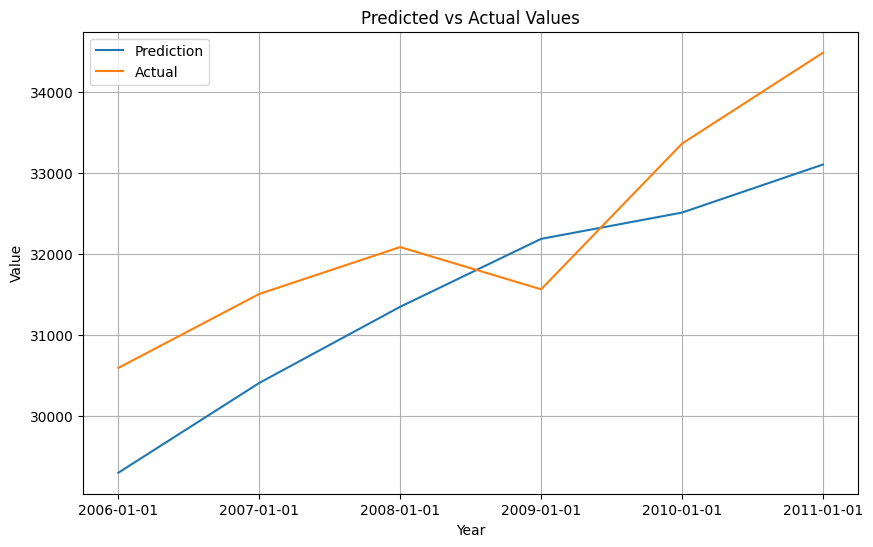

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Prediction'], label='Prediction')
plt.plot(result_df.index, result_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting Validation on the val set

In [13]:
pred_val = saved_model.predict(x_val)

print_metrics(pred_val, y_val, 'Transformer_Scores')

1/1 [==============================] - 0s 9ms/step


,MAE,RMSE,MAPE,R2
Transformer_Scores,349.07,416.58,0.01,0.43


In [14]:
pred_val_flat = pred_val.flatten()
y_val_flat = y_val.flatten()

# Create a DataFrame to compare predictions and actual values
result_df_val = pd.DataFrame({'Prediction': pred_val_flat, 'Actual': y_val_flat})

result_df_val.index = validate_set.index[-5:]

print(result_df_val)

              Prediction      Actual
year                                
2017-01-01  36392.949219  36096.7380
2018-01-01  36586.527344  36826.5080
2019-01-01  37021.816406  37082.5590
2020-01-01  37505.332031  37103.2055
2021-01-01  37870.156250  37123.8520


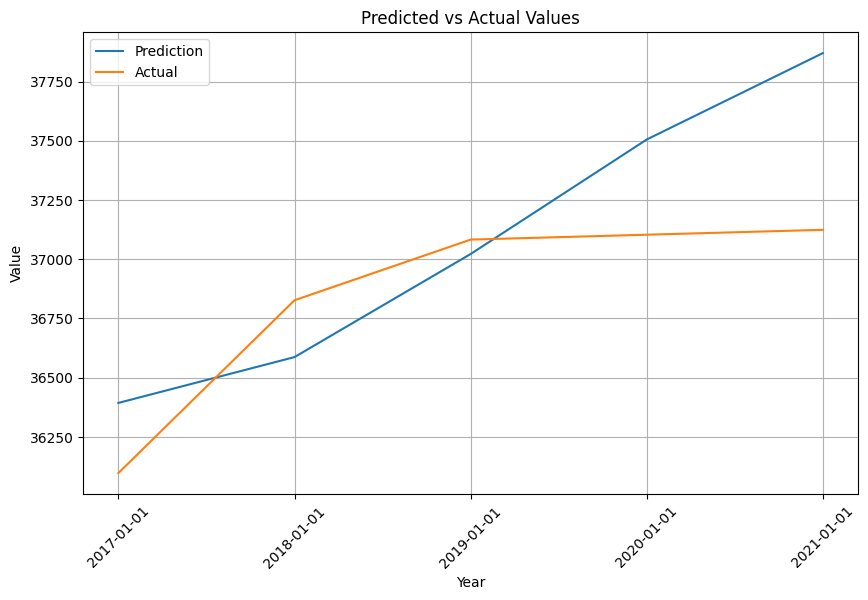

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(result_df_val.index, result_df_val['Prediction'], label='Prediction')
plt.plot(result_df_val.index, result_df_val['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Ensembling of the 2 Best Models 

In [56]:
model_a = load_model('Transformers_Best_Models_and_weights/best_model_weights_89.2867.hdf5')
model_b = load_model('Transformers_Best_Models_and_weights/best_model_weightss_89_R2_0.98.hdf5')

In [57]:
pred_a = model_a.predict(x_test)
pred_b = model_b.predict(x_test)

4/4 [==============================] - 0s 4ms/step


In [58]:
val_pred_a = model_a.predict(x_val)
val_pred_b = model_b.predict(x_val)

4/4 [==============================] - 0s 4ms/step


In [97]:
weight_model_a = 0.6
weight_model_b = 0.4

In [98]:
ensemble_pred = (weight_model_a * pred_a) + (weight_model_b * pred_b)

ensemble_pred_val = ((weight_model_a * val_pred_a) + (weight_model_b * val_pred_b))

# Forecasting using the Ensembled Models

In [99]:
print_metrics(ensemble_pred, y_test, 'Transformer_Ensembled_Scores_TEST')

,MAE,RMSE,MAPE,R2
Transformer_Ensembled_Scores_TEST,276.92,295.91,0.01,0.99


In [100]:
print_metrics(ensemble_pred_val, y_val, 'Transformer_Ensembled_Scores_val')

,MAE,RMSE,MAPE,R2
Transformer_Ensembled_Scores_val,191.03,196.64,0.01,0.94


In [101]:
pred_ensembled_flat = ensemble_pred.flatten()
y_test_flat = y_test.flatten()

# Create a DataFrame to compare predictions and actual values
ensembled_result_df = pd.DataFrame({'Prediction': pred_ensembled_flat, 'Actual': y_test_flat})

ensembled_result_df.index = test_set.index[-127:]

print("TEST Set:")
print("\n")
print(ensembled_result_df)

pred_ensembled_val_flat = ensemble_pred_val.flatten()
y_val_flat = y_val.flatten()

# Create a DataFrame to compare predictions and actual values
ensembled_result_val_df = pd.DataFrame({'Prediction': pred_ensembled_val_flat, 'Actual': y_val_flat})

ensembled_result_val_df.index = validate_set.index[-115:]

print("\n")
print("VAL Set:")
print("\n")
print(ensembled_result_val_df)

TEST Set:


              Prediction        Actual
year                                  
2000-07-01  25417.011719  25560.836000
2000-08-01  25434.812500  25578.704833
2000-09-01  25452.615234  25596.573667
2000-10-01  25470.414062  25614.442500
2000-11-01  25488.218750  25632.311333
...                  ...           ...
2010-09-01  33766.906250  34112.790667
2010-10-01  33860.113281  34206.346000
2010-11-01  33953.320312  34299.901333
2010-12-01  34046.527344  34393.456667
2011-01-01  34139.730469  34487.012000

[127 rows x 2 columns]


VAL Set:


              Prediction        Actual
year                                  
2011-07-01  34511.378906  34746.641000
2011-08-01  34554.492188  34789.912500
2011-09-01  34597.601562  34833.184000
2011-10-01  34640.707031  34876.455500
2011-11-01  34683.812500  34919.727000
...                  ...           ...
2020-09-01  36966.210938  37116.969833
2020-10-01  36967.929688  37118.690375
2020-11-01  36969.640625  37120.410917
2020-12-01  369

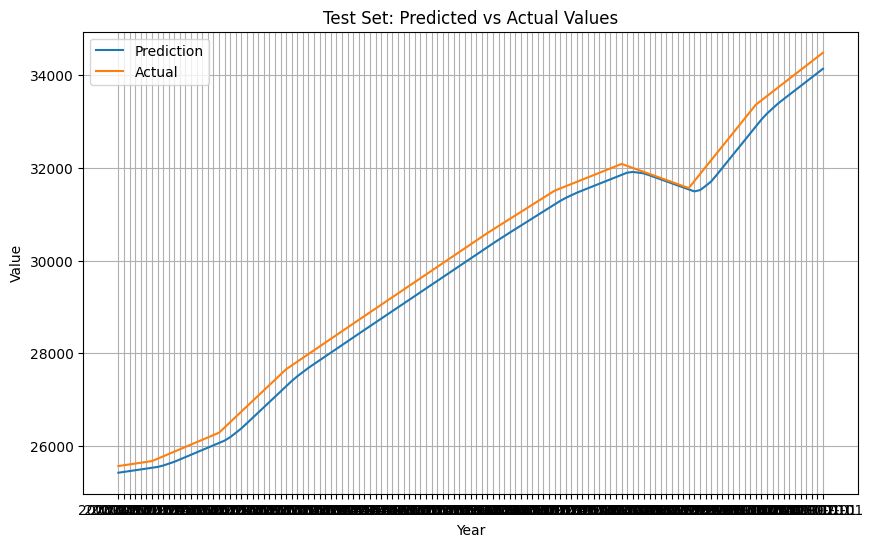

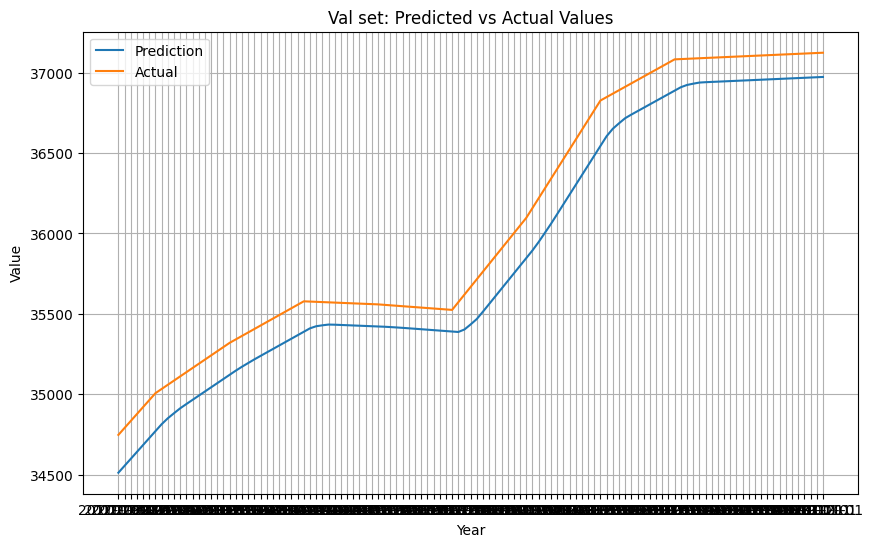

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, ensembled_result_df['Prediction'], label='Prediction')
plt.plot(result_df.index, ensembled_result_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Test Set: Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(result_df_val.index, ensembled_result_val_df['Prediction'], label='Prediction')
plt.plot(result_df_val.index, ensembled_result_val_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Val set: Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting Future Values 2021-02-01 until 2024-01-01 ( Approach 1 ) ( Monthly dataset )

**Creating our dataframe** 

In [28]:
forecast_start_date = pd.Timestamp("2021-02-01")  
forecast_end_date = pd.Timestamp("2024-01-01")    
forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='MS')


forecast_df = pd.DataFrame(index=forecast_index)

#print(forecast_df)

**Forecasting our Values + gaining insights into the input-output process**

In [67]:
initial_sequence = x_val[-5]
forecast_horizon = 36

dates = []
predicted_values = []

for year in range(forecast_horizon):
    # Predict the next value using the trained model
    predicted_value = saved_model.predict(np.expand_dims(initial_sequence, axis=0))

    predicted_values.append(predicted_value)
    
    print(f"Year: {year + 1}")
    print(f"Initial Sequence: {initial_sequence}")
    print(f"Predicted Value: {predicted_value}")
    
    # Updating the initial sequence for the next prediction
    initial_sequence = np.concatenate([initial_sequence[1:], predicted_value], axis=0)

predicted_values_array = np.array(predicted_values).squeeze()

# Add the forecasted values as a new column to the DataFrame
forecast_df["Forecasted_Value"] = predicted_values_array

print(forecast_df)

1/1 [==============================] - 0s 13ms/step
Year: 1
Initial Sequence: [[37108.367125  ]
 [37110.08766667]
 [37111.80820833]
 [37113.52875   ]
 [37115.24929167]]
Predicted Value: [[37253.332]]
1/1 [==============================] - 0s 8ms/step
Year: 2
Initial Sequence: [[37110.08766667]
 [37111.80820833]
 [37113.52875   ]
 [37115.24929167]
 [37253.33203125]]
Predicted Value: [[37304.98]]
1/1 [==============================] - 0s 8ms/step
Year: 3
Initial Sequence: [[37111.80820833]
 [37113.52875   ]
 [37115.24929167]
 [37253.33203125]
 [37304.98046875]]
Predicted Value: [[37370.387]]
1/1 [==============================] - 0s 8ms/step
Year: 4
Initial Sequence: [[37113.52875   ]
 [37115.24929167]
 [37253.33203125]
 [37304.98046875]
 [37370.38671875]]
Predicted Value: [[37417.84]]
1/1 [==============================] - 0s 8ms/step
Year: 5
Initial Sequence: [[37115.24929167]
 [37253.33203125]
 [37304.98046875]
 [37370.38671875]
 [37417.83984375]]
Predicted Value: [[37493.04]]
1/1 [==

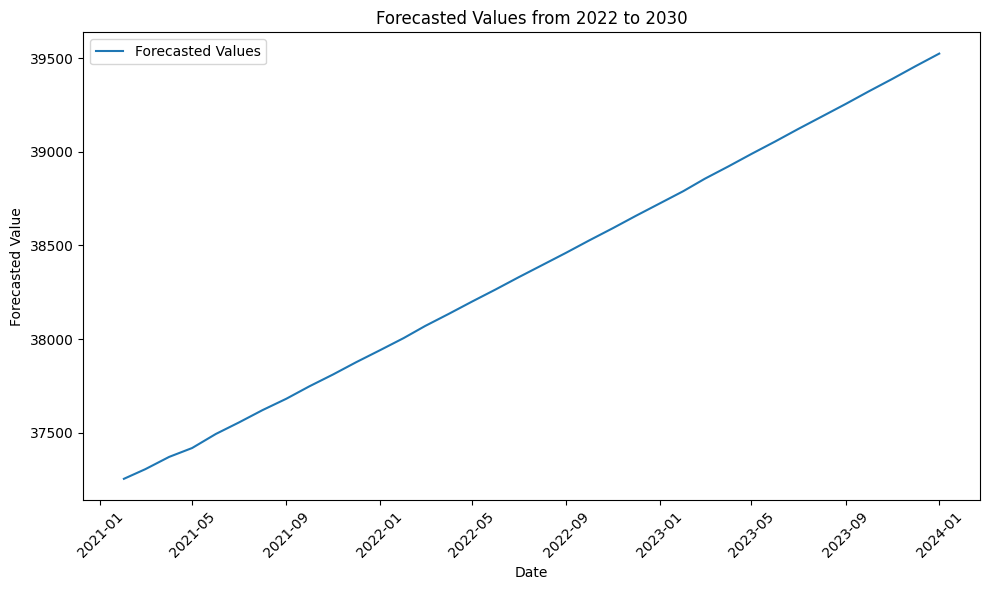

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df["Forecasted_Value"], label="Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Forecasted Value")
plt.title("Forecasted Values from 2022 to 2030")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Forecasting Future Values 2021-02-01 until 2025-01-01 ( Approach 2 ) ( Yearly dataset )

In [56]:
forecast_start_date = pd.Timestamp("2021-02-01")  
forecast_end_date = pd.Timestamp("2026-01-01")    
forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='Y')


forecast_df = pd.DataFrame(index=forecast_index)

#print(forecast_df)

In [58]:
initial_sequence = x_val[-5]
forecast_horizon = 5

dates = []
predicted_values = []

for year in range(forecast_horizon):
    # Predict the next value using the trained model
    predicted_value = saved_model.predict(np.expand_dims(initial_sequence, axis=0))

    predicted_values.append(predicted_value)
    
    print(f"Year: {year + 1}")
    print(f"Initial Sequence: {initial_sequence}")
    print(f"Predicted Value: {predicted_value}")
    
    # Updating the initial sequence for the next prediction
    initial_sequence = np.concatenate([initial_sequence[1:], predicted_value], axis=0)

predicted_values_array = np.array(predicted_values).squeeze()

# Add the forecasted values as a new column to the DataFrame
forecast_df["Forecasted_Value"] = predicted_values_array

print(forecast_df)

1/1 [==============================] - 0s 9ms/step
Year: 1
Initial Sequence: [[35006.27 ]
 [35319.203]
 [35577.535]
 [35558.566]
 [35524.191]]
Predicted Value: [[36392.953]]
1/1 [==============================] - 0s 8ms/step
Year: 2
Initial Sequence: [[35319.203   ]
 [35577.535   ]
 [35558.566   ]
 [35524.191   ]
 [36392.953125]]
Predicted Value: [[36686.17]]
1/1 [==============================] - 0s 8ms/step
Year: 3
Initial Sequence: [[35577.535   ]
 [35558.566   ]
 [35524.191   ]
 [36392.953125]
 [36686.171875]]
Predicted Value: [[37091.11]]
1/1 [==============================] - 0s 7ms/step
Year: 4
Initial Sequence: [[35558.566   ]
 [35524.191   ]
 [36392.953125]
 [36686.171875]
 [37091.109375]]
Predicted Value: [[37512.496]]
1/1 [==============================] - 0s 7ms/step
Year: 5
Initial Sequence: [[35524.191     ]
 [36392.953125  ]
 [36686.171875  ]
 [37091.109375  ]
 [37512.49609375]]
Predicted Value: [[38038.54]]
            Forecasted_Value
2021-12-31      36392.953125
2022-

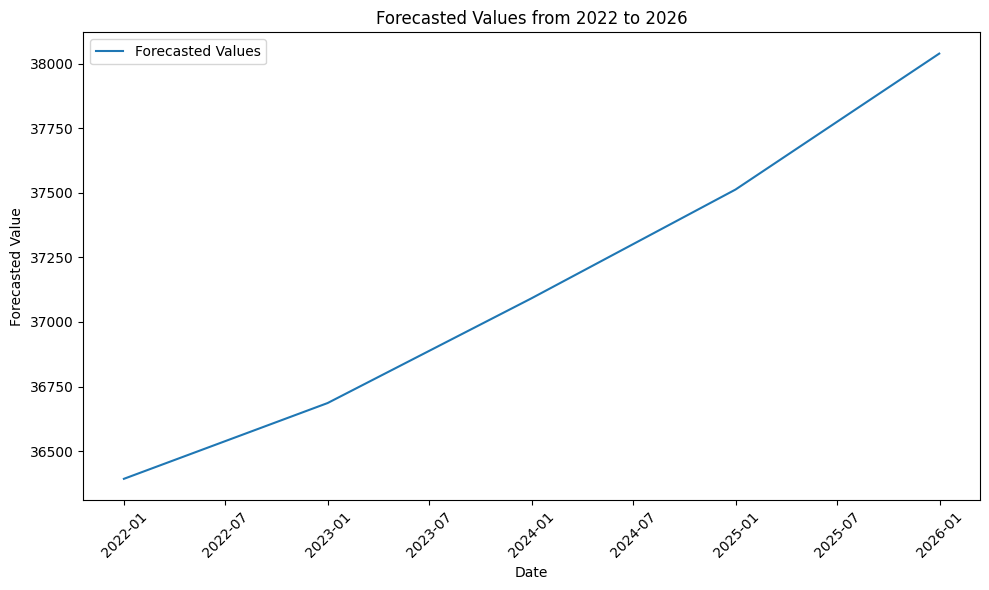

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df["Forecasted_Value"], label="Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Forecasted Value")
plt.title("Forecasted Values from 2022 to 2026")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()